## Комментарии
1. Всегда можно обратиться к Техлог проекту
2. Работаем с Fluidcode т.к. там больше исправлений и пересчетов, чем по FLUIDCODE_PP. Видимо с переменной Fluidcode работали внимательнее. 
3. DEN существует параллельно с RHOB, ее можно удалить. С NEU то же самое, удалить, оставить NPSS.
4. TVD_SS переименовать в TVD_SCS
5. TD надо убрать из Formation
6. Почистил и сохранил датасет в parquet потому что оч долго csv открывался и чистился
7. Переменная NET оказалась только в 2х скважинах, надо бы добавить из Техлог, но можно сделать и в текущем датасете

## Start of working

In [144]:
#Import libs 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from tqdm import tqdm
import textwrap
from statistics import mean
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
import random
import mlflow
import mlflow.sklearn
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 18)

In [2]:
# # Link to my OneDrive where the actual version of TL-dataset is stored
# https://eigcom-my.sharepoint.com/:x:/g/personal/taras_dolgushin_eilink_az/ET4iIiIeUUNCvtixzYiBLFkBc6qYHetw0H0WIqJrR1B6Uw?e=ZUJEIZ

In [3]:
# # Loading the csv file
# data_init = pd.read_csv('ACG_wells_JOINT_BEST_v6.csv', sep=',')

In [4]:
# # Data cleaning of TL-dataset
# df = data_init.copy()
# df = df[1:]
# #Select only neccessary data
# df_cln = df[['wellName', 'DEPTH', 'AREA', 'BADPORLOG', 'Casings', 'FORMATION',
#             'FLANK1', 'FLANK2', 'Fluidcode', 'Fluidcode_mod', 'FLUIDCODE_PP',
#             'LPERM', 'PHIT', 'NET', 
#             'GR_N', 'GRMATRIX', 'GRSHALE','VSH', 'NPSS', 'RHOB', 'RHOF', 'RHOMA', 
#             'RDEEP',  'SON', 'SONSH', 
#             'TVD_SCS','TST', 'DEVI','HAZI','X', 'Y', 'Dip_Azimuth', 'Dip_TRU']]
# #Fill up nan and -9999 values with 0
# df_cln = df_cln.fillna(0)
# df_cln = df_cln.replace(-9999, 0)
# df_cln = df_cln.replace('-9999', '0')

In [5]:
# #Assing proper datatypes for df
# dicttypes = {'wellName':'string', 'DEPTH':'float', 'AREA':'int', 'BADPORLOG':'int', 'Casings':'float', 'FLANK1':'int', 'FLANK2':'int',
#              'Fluidcode':'int', 'Fluidcode_mod':'int','FLUIDCODE_PP':'int','FORMATION':'string', 'GR_N':'float', 'GRMATRIX':'float', 
#              'GRSHALE':'float', 'LPERM':'float', 'NPSS':'float',
#              'PHIT':'float', 'NET':'float', 'RDEEP':'float', 'RHOB':'float', 'RHOF':'float', 'RHOMA':'float', 'TVD_SCS':'float', 'TST':'float',
#              'VSH':'float', 'X':'float', 'Y':'float', 'Dip_Azimuth':'float', 'Dip_TRU':'float'}
# df_cln = df_cln.astype(dicttypes, errors='ignore')
# df_cln.loc[df_cln.FORMATION=='0', 'FORMATION']='None'

In [6]:
# #Save data to parquet
# df_cln.to_parquet('ACG_wells_JOINT_BEST_v6.parquet.gzip', compression='gzip')

## Metadata reading & cleaning

In [7]:
#Loading, distribution wells per Platforms,  and modification of metadata.
metadata_init = pd.read_csv('ACG_wells_metadata.csv', sep=',')
metadata = metadata_init.copy()
metadata = metadata.rename(columns={'X':'X_wellhead', 'Y':'Y_wellhead'})
metadata.Status = metadata.Status.str.strip()
metadata.Status = metadata.Status.str.lower()
metadata.loc[metadata.Status == 'oil', 'Status' ] = 'production oil'
metadata.loc[metadata.Status == 'oil producer', 'Status' ] = 'production oil'
metadata.loc[metadata.Status == 'production', 'Status' ] = 'production oil'
metadata.loc[metadata.Status == 'produiction oil', 'Status' ] = 'production oil'
metadata.loc[metadata.Status == 'production_oil', 'Status' ] = 'production oil'
metadata.loc[metadata.Status == 'abandoned production oil', 'Status' ] = 'abandoned oil'
metadata.loc[metadata.Status == 'abandoned  oil', 'Status' ] = 'abandoned oil'
metadata.loc[metadata.Status == 'abandoned oi', 'Status' ] = 'abandoned oil'
metadata.loc[metadata.Status == 'injector  - water', 'Status' ] = 'injector - water'
metadata.loc[metadata.Status == 'injector water', 'Status' ] = 'injector - water'
metadata.loc[metadata.Status == 'injetor  - water', 'Status' ] = 'injector - water'
metadata.loc[metadata.Status == 'abandoned injector - water per b', 'Status' ] = 'abandoned injector - water'
metadata.loc[metadata.Status == 'plugged and abandoned', 'Status' ] = 'p&a'
metadata.loc[metadata.X_wellhead==118.270, 'X_wellhead'] = 526258.84
metadata.loc[metadata.Y_wellhead==526261.510, 'Y_wellhead'] = 4435802.01
metadata.loc[metadata.well=='C39', 'X_wellhead'] = 526258.840
metadata.loc[metadata.well=='C39', 'Y_wellhead'] = 4435802.010
metadata.loc[metadata.field=='West Azeri', 'field'] = 'WEST AZERI'
metadata.loc[metadata.field=='COP', 'field'] = 'WEST CHIRAG'
metadata.loc[metadata.well=='AZERI2', 'field'] = 'WEST AZERI'
metadata.loc[metadata.well=='AZERI3', 'field'] = 'WEST AZERI'
metadata.loc[metadata.well=='B31', 'field'] = 'CENTRAL AZERI'
metadata.loc[metadata.well=='J28_bpQIP', 'field'] = 'WEST CHIRAG'
field_well_cnt = metadata.groupby('field')['well'].count()
field_well_cnt = field_well_cnt.sort_values(ascending=False).reset_index()
platform = list(field_well_cnt['field'])
figures = list(field_well_cnt['well'])
# fig = go.Figure(data=[go.Pie(labels=platform, values=figures)])
# fig.update_traces(hoverinfo='label+percent', textinfo = 'value', textfont_size=15,
#                   marker=dict(colors=platform, line=dict(color='#000000', width=0.75)))
# fig.update_layout(title_text='Distinution wells per Platforms',
#                   autosize=True, width=500, height=400, margin=dict(l=10,r=10,b=10,t=40))
# fig.show()

In [8]:
# # Distribution wells by current status
# status_well_count = metadata.groupby('Status')['well'].count()
# status_well_count = status_well_count.sort_values(ascending=False).reset_index()
# print('total wells in metadata:', status_well_count.well.sum())
# status_well_count
# count_status = list(status_well_count['Status'])
# fig_status = list(status_well_count['well'])
# fig = go.Figure([go.Bar(x=count_status, y=fig_status, text=fig_status, textposition='auto')])
# fig.update_layout(title_text='Distinution wells by current status',
#                  margin=dict(l=30, r=0, t=40, b=0))
# fig.update_traces(marker_color='rgb(0, 0, 255)', marker_line_color='rgb(0,0,0)',
#                   marker_line_width=1, opacity=0.5)
# fig.show()

## Uploading the main dataframe from parquet

In [334]:
#Read data from parquet
df_prq = pd.read_parquet('ACG_wells_JOINT_BEST_v6.parquet.gzip')
df_prq.rename(columns={'wellName':'well'}, inplace=True)
df_prq = df_prq.set_index('well').join(metadata.set_index('well')).reset_index()
print('wells in df totally:', len(df_prq.well.unique()))

wells in df totally: 440


In [335]:
# Filter data with bad_well_list 
bad_well_list = ['E10Z','Predrill_J01Z', 'Predrill_J08', 'J28_bpQIP']
df_prq = df_prq[~df_prq.well.isin(bad_well_list)]

In [336]:
#Assign any Fluidcode_mod number by variable gross_pay=1 and gross_pay=0 if Fluidcode_mod as NaN
df_prq.loc[df_prq.Fluidcode_mod>0, 'gross_pay'] = 1
df_prq.loc[df_prq.Fluidcode_mod<=0, 'gross_pay'] = 0
df_prq.gross_pay = df_prq.gross_pay.astype('int')

In [344]:
# # Making up dataset for tornado-chart
# df_prq_trndplot = df_prq[['well', 'FORMATION', 'DEPTH', 'TVD_SCS', 'TST', 'Fluidcode_mod', 'gross_pay', 'PHIT', 'LPERM', ]]
# df_prq_trndplot = df_prq_trndplot[df_prq_trndplot.FORMATION.str.contains('Balakhany')]
# df_prq_trndplot.to_csv('df_prq_trndplot.csv', index=False)

In [ ]:
#Getting XY coords of Balakhany formation tops
xy_coord = df_prq[['well', 'FORMATION', 'X', 'Y']]
xy_coord = xy_coord.groupby(['well', 'FORMATION']).apply(lambda x: x.iloc[0]).drop(columns=['well', 'FORMATION']).reset_index()
xy_coord = xy_coord[xy_coord.FORMATION.str.contains('Balakhany')]
xy_coord.sample(3)

## Analize of casing data

In [11]:
# #Overview casings and tops distribution
# df_csg_fm = df_prq[['well', 'DEPTH','TVD_SCS','AREA', 'BADPORLOG', 'Casings', 'FORMATION','X', 'Y']]
# df_csg_fm = df_csg_fm[(df_csg_fm.FORMATION.str.contains('TD')==False)]
# print('all wells', len(df_csg_fm.well.unique()))
# q = np.random.randint(400)
# for well_lst in df_csg_fm.well.unique()[q:q+5]:
#     print(well_lst, 
#           df_csg_fm[df_csg_fm.well == well_lst].Casings.unique(),
#           'top:', df_csg_fm[df_csg_fm.well == well_lst].FORMATION.unique()[0],
#           'bot:', df_csg_fm[df_csg_fm.well == well_lst].FORMATION.unique()[-1])

In [12]:
# #Looking for formation where the casing shoe 13.375 is exist
# df_csg_fm_13_depth = df_csg_fm[(df_csg_fm.Casings== 13.375)].groupby('well').apply(lambda x: x.iloc[-1])
# df_csg_fm_13_depth.drop('well', axis=1, inplace=True)
# df_csg_fm_13_depth = df_csg_fm_13_depth.reset_index()
# # df_csg_fm_13_depth.sample(3)

In [13]:
# #The casing_13 shoe at layer '0' means that casing_13 is higher above any defined tops
# print('total wells in csg 13inch list:',len(df_csg_fm_13_depth.well.unique()))
# bot_13_fm = df_csg_fm_13_depth.FORMATION.value_counts().sort_values(ascending=False).reset_index()
# fm_13 = list(bot_13_fm['FORMATION'])
# fig_13 = list(bot_13_fm['count'])
# fig = go.Figure([go.Bar(x=fm_13, y=fig_13, text=fig_13, textposition='auto')])
# fig.update_layout(title_text='The casing shoe 13inch per FU',
#                  margin=dict(l=10, r=10, t=50, b=10))
# fig.update_traces(marker_color='rgba(153, 51, 51, 0.75)', marker_line_color='rgb(0, 0, 0)',
# marker_line_width=1, opacity=0.75)
# fig.show()

In [14]:
# #Looking for formation where the casing shoe 9.625 is exist
# df_csg_fm_9_depth = df_csg_fm[(df_csg_fm.Casings == 9.625)].groupby('well').apply(lambda x: x.iloc[-1])
# df_csg_fm_9_depth.drop('well', axis=1, inplace=True)
# df_csg_fm_9_depth = df_csg_fm_9_depth.reset_index()
# print('total wells in 9inch list:', len(df_csg_fm_9_depth.well.unique()))
# bot_9_fm = df_csg_fm_9_depth.FORMATION.value_counts().sort_values(ascending=False).reset_index()
# fm_9 = list(bot_9_fm['FORMATION'])
# fig_9 = list(bot_9_fm['count'])
# fig = go.Figure([go.Bar(x=fm_9, y=fig_9, text=fig_9, textposition='auto')])
# fig.update_layout(title_text='The casing shoe 9inch per FU',
#                  margin=dict(l=10, r=10, t=50, b=10))
# fig.update_traces(marker_color='rgba(191, 0, 255, 0.5)', marker_line_color='rgb(0, 0, 0)',
#                   marker_line_width=1, opacity=0.75)
# fig.show()

## Analize of GR_N data

In [15]:
# #Looking for the top formation of GR_N-log 
# df_grn_top = df_prq[(df_prq.GR_N != 0)].groupby('well').apply(lambda x: x.iloc[0])
# df_grn_top.drop('well', axis=1, inplace=True)
# df_grn_top = df_grn_top.reset_index()
# df_grn_top = df_grn_top[['well', 'DEPTH', 'Casings', 'FORMATION','GR_N']]
# print('total wells in GR_N datatset:', len(df_grn_top.well.unique()))
# df_grn_top_lst = df_grn_top.FORMATION.value_counts().sort_values(ascending=False).reset_index()
# print(df_grn_top_lst.FORMATION.unique())
# fm_top_GRN = list(df_grn_top_lst['FORMATION'])
# fig_top_GRN = list(df_grn_top_lst['count'])
# fig = go.Figure([go.Bar(x=fm_top_GRN, y=fig_top_GRN, text=fig_top_GRN, textposition='auto')])
# fig.update_layout(title_text='Top formation of GR_N-log',
#                  margin=dict(l=10, r=10, t=50, b=10))
# fig.update_traces(marker_color='rgba(0, 128, 0, 0.75)', marker_line_color='rgb(204, 0, 0)', marker_line_width=2)
# fig.show()

In [16]:
# #Looking for the bottom formation of GR_N-log 
# df_grn_bot = df_prq[(df_prq.GR_N != 0)].groupby('well').apply(lambda x: x.iloc[-1])
# df_grn_bot.drop('well', axis=1, inplace=True)
# df_grn_bot = df_grn_bot.reset_index()
# df_grn_bot = df_grn_bot[['well', 'DEPTH', 'Casings', 'FORMATION','GR_N']]
# print('total wells in GR_N datatset:', len(df_grn_bot.well.unique()))
# df_grn_bot_lst = df_grn_bot.FORMATION.value_counts().sort_values(ascending=False).reset_index()
# print(df_grn_bot_lst.FORMATION.unique())
# fm_bot_GRN = list(df_grn_bot_lst['FORMATION'])
# fig_bot_GRN = list(df_grn_bot_lst['count'])
# fig = go.Figure([go.Bar(x=fm_bot_GRN, y=fig_bot_GRN, text=fig_bot_GRN, textposition='auto')])
# fig.update_layout(title_text='Bop formation of GR_N-log',
#                  margin=dict(l=10, r=10, t=50, b=10))
# fig.update_traces(marker_color='rgba(0, 128, 0, 0.75)', marker_line_color='rgb(0, 102, 255)', marker_line_width=2)
# fig.show()

In [17]:
# #Looking for GR_N-log from Balakhany till Pereriv zone
# well_gr_top = df_grn_top[df_grn_top.FORMATION.isin(['Balakhany','0','Sabunchi gypsum marker','Balakhany V', 'Sabunchi'])].well.unique()
# well_gr_bot = df_grn_bot[df_grn_bot.FORMATION.isin(['Pereriv E','Pereriv D lower','Pereriv D','Pereriv B','Pereriv C','Pereriv A'])].well.unique()
# big_gr_list = list(set(well_gr_top).intersection(well_gr_bot))
# print('wells total in the list:', len(big_gr_list))

In [18]:
# #Calculation how many wells with long GR_N-log belong to different oilfields
# big_gr_list_df = df_prq[(df_prq.well.isin(big_gr_list)) & (df_prq.X > 0) & (df_prq.Y > 0)]
# big_gr_list_df = big_gr_list_df.set_index('well').join(metadata.set_index('well'), rsuffix='_wh').reset_index()
# big_gr_list_df.rename(columns={'index':'well'}, inplace=True)
# field_count_gr = big_gr_list_df.groupby('well')['field'].apply(lambda x: x.iloc[0]).reset_index()
# well_gr_azeri = len(field_count_gr[field_count_gr.field.isin(['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI'])].well)
# well_gr_chirag = len(field_count_gr[field_count_gr.field.isin(['CHIRAG', 'WEST CHIRAG'])].well)
# well_gr_dwg = len(field_count_gr[field_count_gr.field.isin(['DWG', 'DDGG'])].well)
# well_gr_total = len(field_count_gr.well)
# print('wells with GR on AZERI field:', well_gr_azeri, f'{(well_gr_azeri/well_gr_total)*100:.0f}', '%')
# print('wells with GR on CHIRAG field:', well_gr_chirag, f'{(well_gr_chirag/well_gr_total)*100:.0f}', '%')
# print('wells with GR on DWG field:', well_gr_dwg, f'{(well_gr_dwg/well_gr_total)*100:.0f}', '%')
# print('wells with GR total:', well_gr_total, )

## Analize of RHOB data

In [19]:
# #Looking for the top formation of RHOB+NPSS into long GR_N 
# df_rhob_top = big_gr_list_df[(big_gr_list_df.RHOB != 0)].groupby('well').apply(lambda x: x.iloc[0])
# df_rhob_top.drop('well', axis=1, inplace=True)
# df_rhob_top = df_rhob_top.reset_index()
# df_rhob_top = df_rhob_top[['well', 'DEPTH', 'Casings', 'FORMATION', 'RHOB']]
# print(len(df_rhob_top.well.unique()))
# print(textwrap.fill(str(list(df_rhob_top.FORMATION.unique())),120))
# df_rhob_top_lst = df_rhob_top.FORMATION.value_counts().sort_values(ascending=False).reset_index()
# fm_top_rhob = list(df_rhob_top_lst['FORMATION'])
# fig_top_rhob = list(df_rhob_top_lst['count'])
# fig = go.Figure([go.Bar(x=fm_top_rhob, y=fig_top_rhob, text=fig_top_rhob, textposition='auto')])
# fig.update_layout(title_text='Top formation of RHOB-log',
#                  margin=dict(l=10, r=10, t=50, b=10))
# fig.update_traces(marker_color='rgba(153, 77, 0, 0.75)', marker_line_color='rgb(204, 0, 0)', marker_line_width=2)
# fig.show()


In [20]:
# #Looking for the bot formation of RHOB+NPSS into long GR_N 
# df_rhob_bot = big_gr_list_df[(big_gr_list_df.RHOB != 0)].groupby('well').apply(lambda x: x.iloc[-1])
# df_rhob_bot.drop('well', axis=1, inplace=True)
# df_rhob_bot = df_rhob_bot.reset_index()
# df_rhob_bot = df_rhob_bot[['well', 'DEPTH', 'Casings', 'FORMATION','GR_N']]
# print(len(df_rhob_bot.well.unique()))
# print(textwrap.fill(str(list(df_rhob_bot.FORMATION.unique())),120))
# df_rhob_bot_lst = df_rhob_bot.FORMATION.value_counts().sort_values(ascending=False).reset_index()
# fm_bot_rhob = list(df_rhob_bot_lst['FORMATION'])
# fig_bot_rhob = list(df_rhob_bot_lst['count'])
# fig = go.Figure([go.Bar(x=fm_bot_rhob, y=fig_bot_rhob, text=fig_bot_rhob, textposition='auto')])
# fig.update_layout(title_text='Bot formation of RHOB-log',
#                  margin=dict(l=10, r=10, t=50, b=10))
# fig.update_traces(marker_color='rgba(153, 77, 0, 0.75)', marker_line_color='rgb(0, 102, 255)', marker_line_width=2)
# fig.show()

In [21]:
# #Looking for RHOB+NPSS from Balakhany till Pereriv zone based on GR_N-log Balakhany-Pereriv interval
# well_rhob_top = df_rhob_top[df_rhob_top.FORMATION.isin(['0', 'Surakhany lower anhydrite', 'Seabed', 'Akchagyl', 'Balakhany', 'Surakhany 3', 
#                                                         'Surakhany lower sands', 'Surakhany ogs anhydrite', 'Sabunchi', 'Sabunchi gypsum marker', 
#                                                         'Surakhany', 'Soil Unit 8', 'Surakhany 4'])].well.unique()
# well_rhob_bot = df_rhob_bot[df_rhob_bot.FORMATION.isin(['Pereriv D', 'Pereriv C', 'Pereriv E', 'NKG', 'TD', 'Pereriv B', 'Pereriv D lower', 'Pereriv A',
#                                                         'Lower PK', 'Kirmaku',])].well.unique()
# big_rhob_list = list(set(well_rhob_top).intersection(well_rhob_bot))
# print('wells total in the list:', len(big_rhob_list))

In [22]:
# #Calculation how many wells with long RHOB+NPSS-log belong to different oilfields
# big_rhob_list_df = df_prq[(df_prq.well.isin(big_rhob_list)) & (df_prq.X > 0) & (df_prq.Y > 0)]
# big_rhob_list_df = big_rhob_list_df.set_index('well').join(metadata.set_index('well'), rsuffix='_wh').reset_index()
# big_rhob_list_df.rename(columns={'index':'well'}, inplace=True)
# field_count_rhob = big_rhob_list_df.groupby('well')['field'].apply(lambda x: x.iloc[0]).reset_index()
# well_rhob_azeri = len(field_count_rhob[field_count_rhob.field.isin(['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI'])].well)
# well_rhob_chirag = len(field_count_rhob[field_count_rhob.field.isin(['CHIRAG', 'WEST CHIRAG'])].well)
# well_rhob_dwg = len(field_count_rhob[field_count_rhob.field.isin(['DWG', 'DDGG'])].well)
# well_rhob_total = len(field_count_rhob.well)
# print('wells with RHOB on AZERI field:', well_rhob_azeri, f'{(well_rhob_azeri/well_rhob_total)*100:.0f}', '%' )
# print('wells with RHOB on CHIRAG field:', well_rhob_chirag, f'{(well_rhob_chirag/well_rhob_total)*100:.0f}', '%'  )
# print('wells with RHOB on DWG field:', well_rhob_dwg, f'{(well_rhob_dwg/well_rhob_total)*100:.0f}', '%' )
# print('wells with RHOB total:', well_rhob_total)

In [23]:
#Looking for the intesection & outersection of GR_N & RHOB
# rhob_gr_diff_list = list(set(big_rhob_list).symmetric_difference(big_gr_list))
# len(rhob_gr_diff_list)

In [24]:
#Creating list for Techlog
# print(len(list(set(well_top).intersection(well_bot))))
# print('|'.join(map(str,list(set(well_top).intersection(well_bot)))))

In [25]:
# #Plot wells with GR/RHOB and platforms on the summary map
# field_avg_coord = metadata.groupby('field')[['X_wellhead','Y_wellhead']].mean().reset_index()
# big_gr_list_xy_gb = df_prq[(df_prq.well.isin(big_gr_list)) & 
#                            (df_prq.X > 0) & (df_prq.Y > 0)].groupby('well')[['X','Y']].apply(lambda x: x.iloc[-1]).reset_index()
# big_rhob_list_xy_gb = df_prq[(df_prq.well.isin(big_rhob_list)) & 
#                             (df_prq.X > 0) & (df_prq.Y > 0)].groupby('well')[['X','Y']].apply(lambda x: x.iloc[-1]).reset_index()
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=big_gr_list_xy_gb.X, y=big_gr_list_xy_gb.Y, customdata = big_gr_list_xy_gb[['well']],
#                          marker=dict(color='rgba(20, 200, 70, 0.75)', size=11, line=dict(color='rgb(82, 82, 122)', width=0.5)),
#                          mode='markers', name='only GR',
#                          hovertemplate="".join(["%{customdata[0]}<extra></extra>"])))
# fig.add_trace(go.Scatter(x=big_rhob_list_xy_gb.X, y=big_rhob_list_xy_gb.Y,customdata = big_rhob_list_xy_gb[['well']],
#                          marker=dict(color='rgba(204, 0, 0, 1)', size=8),
#                          mode='markers', name='GR + RHOB',
#                          hovertemplate="".join(["%{customdata[0]}<extra></extra>"])))
# fig.add_trace(go.Scatter(x=field_avg_coord.X_wellhead, y=field_avg_coord.Y_wellhead, customdata = field_avg_coord[['field']],
#                          text=field_avg_coord['field'], textposition="middle right",
#                          marker=dict(color='rgb(0, 0,0)', size=12),
#                          mode='markers+text', name='Platforms', 
#                          marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])))
# fig.update_layout(title_text='TD position of wells with GR and wells with GR+RHOB',
#                   autosize=True, width=900, height=600, margin=dict(l=10,r=10,b=10,t=40))
# fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
# fig.show();

## Data analize in domain of MD

In [26]:
# #Calculation of KH per FU for Balakhany
# op_wells = ['E01Y', 'E01X', 'E02Y', 'E04X', 'E04Y', 'E08', 'E10X', 'E10W',
#        'E11X', 'E12', 'E16W', 'E20Y', 'E28', 'E29', 'E33', 'E34', 'E35A',
#        'E38Z', 'E39', 'J18A', 'J28', 'J29', 'G05', 'G06', 'G07Z', 'G07',
#        'E30Z', 'E30Y', 'E36', 'J25']
# df_prq_kh = df_prq[df_prq.well.isin(op_wells)]
# lst = []
# for w in df_prq_kh.well.unique()[:]:
#     df_well = df_prq_kh[(df_prq_kh.well == w) & (df_prq_kh.FORMATION.str.contains('Balakhany X'))]
#     for f in df_well.FORMATION.unique():
#         df_well_fm = df_well[(df_well.FORMATION == f) & (df_well.Fluidcode_mod != 0)]
#         kh_sum = 0
#         for i in range(len(df_well_fm)):
#             kh_sum += 0.1*df_well_fm.LPERM.iloc[i]
#         lst.append([w, f, round(kh_sum,0)])
# df_res_kh = pd.DataFrame(lst, columns=['well', 'FORMATION', 'KH'])
# # df_res_kh.to_csv('df_bal10_kh_op_inj.csv', sep = ',', index=False)

In [27]:
# #List of layers with gross pay MD > 1.5m into Balakhany
# print(f'wells with gross pay into Balakhany more then {gross_cutoff}m:', len(wells_gross_bal))
# fm_gross_bal = df_prq_gb_fm_gross_flawless[df_prq_gb_fm_gross_flawless.FORMATION.str.contains('Balakhany')].FORMATION.unique()
# print('Variaty of layers names for Balakhany:', len(fm_gross_bal))
# for i in fm_gross_bal:
#     print(i)

In [28]:
# #How many wells with gross pay into Balakhany and long GR_N
# gr_gross_intersect = list(set(wells_gross_bal).intersection(big_gr_list))
# gr_gross_diff = list(set(big_gr_list).symmetric_difference(wells_gross_bal))
# print('Quantity of wells with gross pay Balakhany vs long GR_N:', len(gr_gross_intersect))
# print('Quantity of wells with gross pay Balakhany without long GR_N:', len(gr_gross_diff))

In [29]:
# #Averaging of Phit & Perm per wells and layers for wells where gross pay exist
# df_prq_bal_phit_perm = df_prq[df_prq.FORMATION.str.contains('Balakhany')][['well', 
#                                                                            'DEPTH','TST', 'FORMATION','gross_pay', 
#                                                                            'PHIT', 'LPERM']]
# df_prq_bal_phit_perm_gb = df_prq_bal_phit_perm.groupby(['well','FORMATION']).agg(
#                                                        {'gross_pay':'sum', 'PHIT':'mean', 'LPERM':'mean' }).reset_index()
# df_prq_bal_phit_perm_gb.gross_pay = df_prq_bal_phit_perm_gb.gross_pay/10
# df_prq_bal_phit_perm_gb = df_prq_bal_phit_perm_gb[(df_prq_bal_phit_perm_gb.FORMATION.str.contains('Balakhany')) &
#                                                   (df_prq_bal_phit_perm_gb.gross_pay > 1.5) &
#                                                   (df_prq_bal_phit_perm_gb.PHIT !=0) &
#                                                   (df_prq_bal_phit_perm_gb.LPERM != 0)]
# df_prq_bal_phit_perm_gb = df_prq_bal_phit_perm_gb[~df_prq_bal_phit_perm_gb.well.isin(well_fm_flawed)]
# df_prq_bal_phit_perm_gb.PHIT = df_prq_bal_phit_perm_gb.PHIT.round(2)
# df_prq_bal_phit_perm_gb.LPERM = df_prq_bal_phit_perm_gb.LPERM.round(0)
# df_prq_bal_phit_perm_gb.gross_pay = df_prq_bal_phit_perm_gb.gross_pay.round(1)
# print('Wells with avg phit & perm per layers:',len(df_prq_bal_phit_perm_gb.well.unique()))
# df_prq_bal_phit_perm_gb.sample(3)

In [30]:
# # Bar plot with quantity of records with Avg Phit/Perm !=0 and sum of gross pays > 1.5m per formations
# rcrds_per_layer = df_prq_bal_phit_perm_gb.FORMATION.value_counts().sort_values(ascending=False).reset_index()
# rcrds_per_layer.rename(columns={'index':'layer', 'FORMATION':'qty'}, inplace=True)
# rcrds_per_layer.sort_values(by='qty',ascending=False)
# fig = px.bar(rcrds_per_layer, x='layer', y='qty', text_auto=True, color='qty', title='Phit avg per wells & layers', height=500)
# fig.update_layout(margin=dict(l=10, r=10, t=30, b=10))
# fig.show()

In [31]:
# #Creating histograms for AVG Phit per Balakhany VIII
# for fm in df_prq_bal_phit_perm_gb.FORMATION.unique():
#     if 'Balakhany VIII' in fm:
#         df_fm = df_prq_bal_phit_perm_gb[df_prq_bal_phit_perm_gb.FORMATION == fm]
#         fig = go.Figure()
#         fig.add_trace(go.Histogram(x=df_fm.PHIT, nbinsx=25))
#         fig.update_layout( title = fm,
#                            height=300, 
#                            width=500, 
#                            margin=dict(l=10, r=10, t=30, b=10),
#                            xaxis_title='PHIT',
#                            xaxis=dict(range=[0, .25]))
#         fig.update_traces(opacity=0.75)
#         fig.show()

In [32]:
# #Creating histograms for AVG Phit per Balakhany X
# for fm in df_prq_bal_phit_perm_gb.FORMATION.unique():
#     if 'Balakhany X' in fm:
#         df_fm = df_prq_bal_phit_perm_gb[df_prq_bal_phit_perm_gb.FORMATION == fm]
#         fig = go.Figure()
#         fig.add_trace(go.Histogram(x=df_fm.PHIT, nbinsx=25))
#         fig.update_layout( title = fm,
#                            height=300, 
#                            width=500, 
#                            margin=dict(l=10, r=10, t=30, b=10),
#                            xaxis_title='PHIT',
#                            xaxis=dict(range=[0, .25]))
#         fig.update_traces(opacity=0.75)
#         fig.show()

In [33]:
# #Overview histogram for the Sum of gross pay per formation
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=df_prq_bal_phit_perm_gb.gross_pay, 
#                            xbins=dict( # bins used for histogram
#                            start=0.0,
#                            end=900.0,
#                            size=5.0)))
# fig.update_traces(hovertemplate='Heff: %{x} <extra></extra>')
# fig.update_layout(  title = 'Sum of gross pay per formation for whole Balakhany dataset',
#                     height=300, 
#                     width=1500,
#                     margin=dict(l=30, r=10, t=30, b=10),
#                     xaxis_title='Sum of gross pay per fm, m',
#                     yaxis_title='Qty of records in df')
# fig.show()
# print('Total numver of records in df with averaginf phi/perm per wells & fms:', df_prq_bal_phit_perm_gb.shape[0])
# print('Wells into dataframe of averaging properties for Balakhany fm:',len(df_prq_bal_phit_perm_gb.well.unique()))
# print('Wells with gross pay for Bal > 100m:', len(df_prq_bal_phit_perm_gb[(df_prq_bal_phit_perm_gb.gross_pay>100)].well.unique()))

In [34]:
# #Creating x-plots Phit vs Gross pay per Balakhany VIII
# for fm in df_prq_bal_phit_perm_gb.FORMATION.unique():
#     if 'Balakhany VIII' in fm:
#         df_fm = df_prq_bal_phit_perm_gb[df_prq_bal_phit_perm_gb.FORMATION == fm]
#         fig = go.Figure()
#         fig.add_trace(go.Scatter(x=df_fm.PHIT, y=df_fm.gross_pay, customdata = df_fm[['well']], mode='markers'))
#         fig.update_layout( title = fm,
#                            height=400, 
#                            width=500, 
#                            margin=dict(l=10, r=10, t=40, b=10),
#                            xaxis_title='PHIT',
#                            xaxis=dict(range=[0, .3]),
#                            yaxis_title='Gross pay',
#                            yaxis=dict(range=[0, 200]))
#         fig.update_traces(opacity=1,
#                           hovertemplate="<br>".join([
#                           "phit: %{x}",
#                           "grosspay: %{y}",
#                           "wellnum: %{customdata[0]}"]))
#         fig.show()

In [35]:
# # Experiments with KH calculation by vector-based method
#  df_prq_bal_phit_h = df_prq_bal_phit_perm.groupby(by=['well','FORMATION'])['PHIT'].sum().groupby(level='well').cumsum().rename('PHIT*H').reset_index()
# df_prq_bal_phit_h = df_prq_bal_phit_perm_h.groupby(by=['well','FORMATION'])['PHIT'].sum().rename('PHIT*H').reset_index()

In [36]:
# #Averaging of Phit & Perm per wells and layers for wells with long GR_N
# df_prq_bal_phit_perm_gr = df_prq[df_prq.well.isin(gr_gross_intersect)][['well', 'FORMATION','NET_flcd_mod', 'PHIT', 'LPERM']]
# df_prq_bal_phit_perm_gr_gb = df_prq_bal_phit_perm_gr.groupby(['well','FORMATION']).agg(
#                                         {'NET_flcd_mod':'sum', 'PHIT':'mean', 'LPERM':'mean' }).reset_index()
# df_prq_bal_phit_perm_gr_gb.NET_flcd_mod = df_prq_bal_phit_perm_gr_gb.NET_flcd_mod/10
# df_prq_bal_phit_perm_gr_gb = df_prq_bal_phit_perm_gr_gb[(df_prq_bal_phit_perm_gr_gb.NET_flcd_mod > 1.5) &
#                                                         (df_prq_bal_phit_perm_gr_gb.PHIT !=0) &
#                                                         (df_prq_bal_phit_perm_gr_gb.LPERM != 0)]
# print('Wells with avg phit & perm per layers:',len(df_prq_bal_phit_perm_gr_gb.well.unique()))
# # df_prq_bal_phit_perm_gr_gb

In [37]:
# # Join-inner dataframe with avg props and df_prq
# df_prq_avg_prop = df_prq.set_index(['well', 'FORMATION']).join(df_prq_bal_phit_perm_gb.set_index(['well', 'FORMATION']), how='inner', rsuffix='_avg').reset_index()
# print('Wells after inner join:', len(df_prq_avg_prop.well.unique()))

In [38]:
# #Displaing data in format of depth-plot. Inprogress.
# df_by_well = df_prq[df_prq.well == well_rnd].sort_values(by='DEPTH')
# depthmd = df_by_well.DEPTH
# phit = df_by_well.PHIT
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=phit, y=depthmd, 
#                          name='PHIT', mode='lines'))
# fig.update_layout(
#     title=well_rnd,
#     xaxis_title='PHIT',
#     xaxis=dict(range=[0, 0.3]),  # Set x-axis limits for PHIT
#     yaxis_title='MD',
#     height=1200,
#     width=350)
# fig.update_yaxes(autorange="reversed")
# fig.show()

## KH calculation for all wells

In [39]:
#KH calculation in MD domain for all wells
lst = []
for w in tqdm(df_prq.well.unique()):
    df_well = df_prq[(df_prq.well == w) & (df_prq.FORMATION.str.contains('Balakhany'))]
    for f in df_well.FORMATION.unique():
        df_well_fm = df_well[(df_well.FORMATION == f) & (df_well.Fluidcode_mod != 0)]
        kh_sum = 0
        for i in range(len(df_well_fm)):
            kh_sum += 0.1*df_well_fm.LPERM.iloc[i]
        lst.append([w, f, round(kh_sum,0)])
df_res_kh = pd.DataFrame(lst, columns=['well', 'FORMATION', 'KH'])

In [40]:
# #Saving KH in MD domain to .csv
# df_res_kh.to_csv('df_bal_kh_full.csv', sep = ',', index=False)

In [41]:
#Average deviation per well & formation
df_prq_devi = df_prq.groupby(['well','FORMATION'])['DEVI'].mean().reset_index()
df_prq_devi.DEVI = round(df_prq_devi.DEVI)
# df_prq_devi

In [45]:
#Reading csv with bal_kh_full anf joining xy-coord to datafram with KH full
df_res_kh = pd.read_csv('df_bal_kh_full.csv')
df_res_kh_xy = df_res_kh.set_index(['well','FORMATION']).join(xy_coord.set_index(['well','FORMATION'])).reset_index()
# df_res_kh_xy.KH = df_res_kh_xy.KH+0.001 
df_res_kh_xy['KH_log10'] = np.log10(df_res_kh_xy.KH)
df_res_kh_xy = df_res_kh_xy.set_index(['well','FORMATION']).join(df_prq_devi.set_index(['well','FORMATION'])).reset_index()
df_prq_wstat = df_prq[['well', 'Status']].groupby('well')['Status'].apply(lambda x: x.iloc[0]).reset_index()
df_res_kh_xy = df_res_kh_xy.set_index('well').join(df_prq_wstat.set_index('well')).reset_index()
df_res_kh_xy.sample(3)

,well,FORMATION,KH,X,Y,KH_log10,DEVI,Status
1901,B16Y,Balakhany VIII 5,22297.000,530833.803,4431079.597,4.348,62.000,abandoned
4426,D09Z,Balakhany IX lower shale,0.000,538145.791,4431244.185,-inf,20.000,injector - water
1511,B04,Balakhany X sand,4517.000,531146.171,4433437.344,3.655,43.000,abandoned oil


In [47]:
#KH in MD domain for Balakhany VIII sand and color it by inclination data
fig = go.Figure()
field_avg_coord = metadata.groupby('field')[['X_wellhead','Y_wellhead']].mean().reset_index()
df_res_kh_xy_8 = df_res_kh_xy[(df_res_kh_xy.FORMATION.str.contains('Balakhany X sand')) & (df_res_kh_xy.KH_log10 > 0) & 
                              (~df_res_kh_xy.Status.isin(['abandoned injector - water', 'injector - water',
                                                          'abandoned injector - gas', 'injector - gas']))]
df_res_kh_xy_8_inj = df_res_kh_xy[(df_res_kh_xy.FORMATION.str.contains('Balakhany X sand')) & (df_res_kh_xy.KH_log10 > 0) &
                                  (df_res_kh_xy.Status.isin(['abandoned injector - water', 'injector - water',
                                                             'abandoned injector - gas', 'injector - gas']))]
fig.add_trace(go.Scatter(x=df_res_kh_xy_8.X, y=df_res_kh_xy_8.Y, customdata = df_res_kh_xy_8[['well', 'KH', 'DEVI']],
                         marker=dict(color=df_res_kh_xy_8.DEVI, size=df_res_kh_xy_8.KH*0.001, line=dict(color='rgb(47, 57, 61)', width=0.5), 
                         colorscale='agsunset', showscale=True),
                         mode='markers', name='KH non-inj',
                         hovertemplate="".join(["well:%{customdata[0]}, KH:%{customdata[1]}, INC:%{customdata[2]}<extra></extra>"])))
fig.add_trace(go.Scatter(x=df_res_kh_xy_8_inj.X, y=df_res_kh_xy_8_inj.Y, customdata = df_res_kh_xy_8_inj[['well', 'KH', 'DEVI']],
                         marker=dict(color=df_res_kh_xy_8_inj.DEVI, size=df_res_kh_xy_8_inj.KH*0.001, symbol="diamond",
                         line=dict(color='rgb(0, 0, 0)', width=1.5), colorscale='agsunset', showscale=True),
                         mode='markers', name='KH inj',
                         hovertemplate="".join(["well:%{customdata[0]}, KH:%{customdata[1]}, INC:%{customdata[2]}<extra></extra>"])))
fig.add_trace(go.Scatter(x=field_avg_coord.X_wellhead, y=field_avg_coord.Y_wellhead, customdata = field_avg_coord[['field']],
                         text=field_avg_coord['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])))
fig.update_layout(title_text='Balakhany VIII sand KH, color=f(DEVI)',
                  autosize=True, width=1200, height=700, margin=dict(l=10,r=10,b=10,t=40))
fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
fig.show()
print('wells on map ', len(df_res_kh_xy_8.well.unique()))

wells on map  170


In [48]:
#KH in MD domain for Balakhany X sand and color it by inclination data
fig = go.Figure()
df_res_kh_xy_10 = df_res_kh_xy[(df_res_kh_xy.FORMATION.str.contains('Balakhany X sand')) & (df_res_kh_xy.KH_log10 > 0) & 
                               (~df_res_kh_xy.Status.isin(['abandoned injector - water', 'injector - water',
                                                          'abandoned injector - gas', 'injector - gas']))]
df_res_kh_xy_10_inj = df_res_kh_xy[(df_res_kh_xy.FORMATION.str.contains('Balakhany X sand')) & (df_res_kh_xy.KH_log10 > 0) &
                                   (df_res_kh_xy.Status.isin(['abandoned injector - water', 'injector - water',
                                                              'abandoned injector - gas', 'injector - gas']))]
fig.add_trace(go.Scatter(x=df_res_kh_xy_10.X, y=df_res_kh_xy_10.Y, customdata = df_res_kh_xy_10[['well', 'KH', 'DEVI']],
                         marker=dict(color=df_res_kh_xy_10.DEVI, size=df_res_kh_xy_10.KH*0.001, line=dict(color='rgb(47, 57, 61)', width=0.5),
                         colorscale='agsunset', showscale=True),
                         mode='markers', name='KH non-inj',
                         hovertemplate="".join(["well:%{customdata[0]}, KH:%{customdata[1]}, INC:%{customdata[2]}<extra></extra>"])))
fig.add_trace(go.Scatter(x=df_res_kh_xy_10_inj.X, y=df_res_kh_xy_10_inj.Y, customdata = df_res_kh_xy_10_inj[['well', 'KH', 'DEVI']],
                         marker=dict(color=df_res_kh_xy_10_inj.DEVI, symbol="diamond", size=df_res_kh_xy_10.KH*0.001, line=dict(color='rgb(0, 0, 0)', width=1.5)),
                         mode='markers', name='KH inj',
                         hovertemplate="".join(["well:%{customdata[0]}, KH:%{customdata[1]}, INC:%{customdata[2]}<extra></extra>"])))
fig.add_trace(go.Scatter(x=field_avg_coord.X_wellhead, y=field_avg_coord.Y_wellhead, customdata = field_avg_coord[['field']],
                         text=field_avg_coord['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])))
fig.update_layout(title_text='Balakhany X sand KH, color=f(DEVI)',
                  autosize=True, width=1200, height=700, margin=dict(l=10,r=10,b=10,t=40))
fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
fig.show()
print('wells on map ', len(df_res_kh_xy_10.well.unique()))

wells on map  170


## Analize of H_md/H_tst data

In [50]:
# #Calculation total height of gross pay per well and formation with sub-zones with cut-off 1.5m of gross pay.
# #Selection of wells with gross pay > 1.5m into Balakhany
# gross_cutoff = 1.5
# df_prq_gb_fm_gross = df_prq.groupby(['well', 'FORMATION'])['gross_pay'].sum().reset_index()
# df_prq_gb_fm_gross.gross_pay = df_prq_gb_fm_gross.gross_pay/10
# df_prq_gb_fm_gross = df_prq_gb_fm_gross[(df_prq_gb_fm_gross.gross_pay>gross_cutoff) &
#                                         (df_prq_gb_fm_gross.FORMATION.str.contains('Balakhany'))]
# wells_gross_bal = df_prq_gb_fm_gross[df_prq_gb_fm_gross.FORMATION.str.contains('Balakhany')].well.unique()
# print(f'wells with gross pay into Balakhany more then {gross_cutoff}m:', len(wells_gross_bal))
# #Wells without Horizon, D34, etc in layers name
# well_fm_flawed = df_prq_gb_fm_gross[df_prq_gb_fm_gross.FORMATION.str.contains('Horizon') | 
#                    df_prq_gb_fm_gross.FORMATION.str.contains('D34')].well.unique()
# df_prq_gb_fm_gross_flawless = df_prq_gb_fm_gross[~df_prq_gb_fm_gross.well.isin(well_fm_flawed)]
# print(f'wells with gross pay into corrected Balakhany more then {gross_cutoff}m:', len(df_prq_gb_fm_gross_flawless.well.unique()))
# # tot_well = len(df_prq.well.unique())
# # well_bal_corr = len(df_prq_gb_fm_gross_flawless.well.unique())
# # well_gr = len(field_count_gr.well)
# # well_rhob = len(field_count_rhob.well)
# # non_bal = tot_well - well_bal_corr
# # colors = ['Non-Balakhany wells', 'Balakhany wells', 'wells only GR', 'wells GR+RHOB']
# # figures = [non_bal, well_bal_corr-well_gr, well_gr-well_rhob, well_rhob]
# # fig = go.Figure(data=[go.Pie(labels=colors, values=figures)])
# # fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=15,
# #                   marker=dict(colors=colors, line=dict(color='#000000', width=1)))
# # fig.update_layout(title_text=f'{tot_well} wells, wells w/ Balakhany tops, GR and GR+RHOB',
# #                   autosize=False, width=500, height=400, margin=dict(l=10,r=10,b=10,t=40))
# # fig.show()

In [51]:
# #Loocking for wells with strange well top's names
# print('well Horizon Bal X', df_prq[(df_prq.FORMATION.str.contains('Horizon Balakhany X'))].well.unique())
# print('well Horizon Bal VIII', df_prq[(df_prq.FORMATION.str.contains('Horizon Balakhany VIII'))].well.unique())

In [52]:
# #Deleting thin Hmd layers from Bal VIII and Bal X. Dataset preparation.
# df_bal8_10 = df_prq[(df_prq.FORMATION.str.contains('Balakhany VIII')) | (df_prq.FORMATION.str.contains('Balakhany X'))]

In [53]:
# #Deleting thin Hmd layers from Bal VIII and Bal X. Dataset vizualization.

# #1.Creating dataset for Bal VIII & Bal X +
# #2.Run loop to get tops and bottoms of gross_pay==1 + 
# #3.Calculate Hmd of gross_pay==1, assign then from tops of interv till gross_pay=1 +
# #4.Think about window fucntion to calc Hmd via well-fm-gross_pay -
# #5.Filtrate Hmd list to remove Hmd<1m  +
# #6.Make up dataframe column with Hmd and assign Hmd to the top of gross_pay -

# # a12 = random_well()
# # print('well', a12)
# a12 = 'E25'
# df_bal8_10_test = df_bal8_10[df_bal8_10.well == a12][['well','DEPTH','FORMATION','gross_pay', 'GR_N']]
# print('MD Hsum before', round(df_bal8_10_test.groupby('well')['gross_pay'].sum()*0.1).iloc[0])
# df_bal8_10_test.iloc[0]['gross_pay'] = 0
# df_bal8_10_test.iloc[-1]['gross_pay'] = 0
# md_top = [df_bal8_10_test.iloc[i]['DEPTH'] for i in range(len(df_bal8_10_test)-1) 
#           if (df_bal8_10_test.iloc[i][3] == 1 and df_bal8_10_test.iloc[i-1][3] == 0)]
# md_bot = [df_bal8_10_test.iloc[i]['DEPTH'] for i in range(len(df_bal8_10_test)-1) 
#           if (df_bal8_10_test.iloc[i][3] == 1 and df_bal8_10_test.iloc[i+1][3] == 0)]
# h_md = [round(md_bot[j]-md_top[j],1) for j in range(len(md_bot))]
# bl_md_top = []
# bl_md_bot = []
# sumk = 0
# for k in range(len(h_md)):
#     if h_md[k] <2:
#         bl_md_top.append(md_top[k])
#         bl_md_bot.append(md_bot[k])
# for j in range(len(bl_md_bot)):
#     df_bal8_10_test.loc[((df_bal8_10_test.DEPTH >= bl_md_top[j]) &(df_bal8_10_test.DEPTH <= bl_md_bot[j])), 'gross_pay'] = 0
# print('MD Hsum after', round(df_bal8_10_test.groupby('well')['gross_pay'].sum()*0.1).iloc[0])
# fig = make_subplots(specs=[[{"secondary_y": True}]])
# x = df_bal8_10_test[(df_bal8_10_test.FORMATION.str.contains('Balakhany VIII sand'))]['DEPTH']
# y_gr = df_bal8_10_test[(df_bal8_10_test.FORMATION.str.contains('Balakhany VIII sand'))]['GR_N']
# y_gpay = df_bal8_10_test[(df_bal8_10_test.FORMATION.str.contains('Balakhany VIII sand'))]['gross_pay']
# fig.add_trace(go.Scatter(x=x, y=y_gr, name='GR', line=dict(color='green', width=2)), secondary_y=False)
# fig.add_trace(go.Scatter(x=x, y=y_gpay, name='gross_pay', fill='tozeroy', line=dict(color='rgba(237,158,12,0.33)', width=1)), secondary_y=True)
# fig.update_yaxes(title_text='GR', showgrid=False)
# fig.update_xaxes(autorange=True)
# fig.update_layout(title=a12 + ' Balakhany X', xaxis_title='MD', xaxis=dict(range=[0, 150]),yaxis_title='GR', height=300, width=1200,
#                   legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(255,255,255,0.33)', bordercolor='Black',borderwidth=1),
#                   margin=dict(l=00,r=00,b=0,t=35))
# fig.show()

In [54]:
# #Calculating gross_tst data for gross pay via MD
# df_lst = []
# for well_in_loop in tqdm(df_prq_gb_fm_gross_flawless.well.unique()):
#     well_lst = []
#     df_prq_tst = df_prq[['well', 'DEPTH', 'TST', 'FORMATION', 'gross_pay']]
#     df_prq_tst = df_prq_tst[df_prq_tst.FORMATION.str.contains('Balakhany VIII sand') & (df_prq_tst.well==well_in_loop)]
#     for fm in df_prq_tst.FORMATION.unique():
#         data = df_prq_tst[df_prq_tst.FORMATION==fm][['well', 'DEPTH', 'TST', 'gross_pay']]
#         data.iloc[0, 3] = 0
#         data.iloc[-1, 3] = 0
#         tst_top = []
#         tst_bot = []
#         h_tst = []
#         tst_top = [data.iloc[i]['TST'] for i in range(len(data)-1)
#                   if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i-1]['gross_pay']==0)]
#         tst_bot = [data.iloc[i]['TST'] for i in range(len(data)-1)
#                   if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i+1]['gross_pay']==0)]   
#         # for i in range(len(data)-1):
#         #     if data.iloc[i][3] == 1 and data.iloc[i-1][3] == 0:
#         #         tst_top.append(data.iloc[i][2])
#         #     if data.iloc[i][3] == 1 and data.iloc[i+1][3]== 0:
#         #         tst_bot.append(data.iloc[i][2])
#         # if data.iloc[-1][3] == 1:
#         #     tst_bot.append(data.iloc[-1][2])
#         h_tst = [(tst_bot[j]-tst_top[j]) for j in range(len(tst_top))] 
#         # for j in range(len(tst_top)):
#         #     h_tst.append(tst_bot[j]-tst_top[j])  
#         well_lst.append([data.iloc[0]['well'], fm, round(sum(h_tst),2)])
#     df_test_tst = pd.DataFrame(well_lst, columns = ['well', 'FORMATION', 'gross_tst'])
#     pd.options.display.max_rows = 30
#     df_lst.append(df_test_tst)
# pd.concat(df_lst)

In [55]:
# #Saving result if TST loop to the .csv file
# df_prq_gross_tstsum_init = pd.concat(df_lst)
# df_prq_gross_tstsum = df_prq_gross_tstsum_init.copy()
# df_prq_gross_tstsum.to_csv('df_prq_gross_tst_v3.csv')

In [56]:
# #Script to check TST calculation for the separate well
# fm = 'Balakhany VI lower shale'
# well_name = 'J30'
# data = df_prq[(df_prq.FORMATION==fm) & (df_prq.well==well_name)][['well', 'DEPTH', 'TST', 'gross_pay', 'FORMATION']]
# data.iloc[0, 3] = 0
# data.iloc[-1, 3] = 0
# well_lst = []
# tst_top = []
# tst_bot = []
# h_tst = []
# # if data.iloc[0][3] == 1:
#     # print(fm, 'check top', data.iloc[0][2])
# #     tst_top.append(data.iloc[0][2])
# for i in range(len(data)-1):
#     # print(data.iloc[i][1], data.iloc[i][2],data.iloc[i][3])
#     if data.iloc[i][3] == 1 and data.iloc[i-1][3] == 0:
#         tst_top.append(round(data.iloc[i][2],2))
#     if data.iloc[i][3] == 1 and data.iloc[i+1][3]== 0:
#         tst_bot.append(round(data.iloc[i][2],2))
# if data.iloc[-1][3] == 1:
#     # print(fm, 'check bot', data.iloc[-1][2])
#     tst_bot.append(round(data.iloc[-1][2],2)) 
# print(well_name, fm, tst_top)
# print(well_name, fm, tst_bot)
# for j in range(len(tst_top)):
#     h_tst.append(round(tst_bot[j]-tst_top[j],2))  
# print(well_name, fm, h_tst)
# print(well_name, fm, sum(h_tst))


In [57]:
# #Upload gross_tst dataset v1 and assement how many broken data into TST dataset
# df_prq_gross_tstsum = pd.read_csv('C:\jupyter\SPP\df_prq_gross_tstsum.csv')
# df_prq_gross_tstsum = df_prq_gross_tstsum[['well', 'FORMATION', 'TST_sum', 'tst_qc']]
# df_prq_gross_tstsum.tst_qc = df_prq_gross_tstsum.tst_qc.astype('int')
# df_prq_gross_tstsum.loc[df_prq_gross_tstsum.TST_sum == 0, 'tst_qc'] = 0
# df_prq_gross_tstsum.loc[df_prq_gross_tstsum.TST_sum > 0, 'tst_qc'] = 1
# df_prq_gross_tstsum.loc[df_prq_gross_tstsum.TST_sum < 0, 'tst_qc'] = 2
# print(df_prq_gross_tstsum.tst_qc.value_counts(normalize=True))
# df_prq_gross_tstsum.shape

## Gross_tst & PHIT data analize

In [58]:
# #Getting a random well num
# def random_well():
#     well_rnd = df_prq.well.sample(1).reset_index().iloc[0][1]
#     return well_rnd

In [59]:
#Upload the TST dataset v3 and assement how many broken data into TST dataset
df_prq_gross_tstsum2 = pd.read_csv('C:\jupyter\SPP\df_prq_gross_tst_v3.csv')
df_prq_gross_tstsum2.loc[df_prq_gross_tstsum2.TST_sum == 0, 'tst_qc'] = 0
df_prq_gross_tstsum2.loc[df_prq_gross_tstsum2.TST_sum > 0, 'tst_qc'] = 1
df_prq_gross_tstsum2.loc[df_prq_gross_tstsum2.TST_sum < 0, 'tst_qc'] = 2
df_prq_gross_tstsum2.tst_qc = df_prq_gross_tstsum2.tst_qc.astype('int')
df_prq_gross_tstsum2 = df_prq_gross_tstsum2[['well', 'FORMATION', 'TST_sum', 'tst_qc']]
# print('tst_qc=1:', df_prq_gross_tstsum2.tst_qc.value_counts(normalize=True)[1]) 
# print('tst_qc=0:', df_prq_gross_tstsum2.tst_qc.value_counts(normalize=True)[0]) 
# print('df shape:', df_prq_gross_tstsum2.shape)


In [60]:
# #Calculation wells with TST Balakhany
# print('wells with TST in Balakhany:', len(df_prq_gross_tstsum2.well.unique()))
# print('total quatity of wells in TL-dataset:',len(df_prq.well.unique()))

In [61]:
# #Making up the full-scale dataset of selected by TST wells for Balakhany fm 
# df_phit_perm_bal_sel = df_prq[(df_prq.well.isin(df_prq_gross_tstsum2.well.unique())) & (df_prq.FORMATION.str.contains('Balakhany'))]

In [62]:
# #Checking formation's name for Balakhany dataframe
# df_prq_gross_tstsum2.FORMATION.unique()

In [63]:
# #Histogramm for Htst > 1.5m of Balakhany wells 
# fig = px.histogram(df_prq_gross_tstsum2[df_prq_gross_tstsum2.TST_sum>1], x="TST_sum", width=1200, height=300)
# fig.update_layout(title='Overall TST_sum histogramm for whole Balakhany',margin=dict(l=0, r=10, t=40, b=0))
# fig.update_xaxes(showgrid=True, minor=dict(tickcolor="white", showgrid=True))
# fig.show()

In [64]:
# # Histogram of TST_sum > 33m
# df_fm_tst_33 = df_prq_gross_tstsum2[(df_prq_gross_tstsum2.FORMATION == 'Balakhany VIII sand') & (df_prq_gross_tstsum2.TST_sum > 33)]
# fig = px.histogram(df_fm_tst_33, x="TST_sum", width=600, height=300)
# fig.update_layout(title='TST_sum > 33m histogramm for whole Balakhany', margin=dict(l=0, r=10, t=40, b=0))
# fig.update_xaxes(showgrid=True, minor=dict(tickcolor="white", showgrid=True))
# fig.show()

In [65]:
# # List of TST_sum > 33m
# df_fm_tst = df_prq_gross_tstsum2[(df_prq_gross_tstsum2.FORMATION == 'Balakhany VIII sand') & (df_prq_gross_tstsum2.TST_sum > 100)]
# df_fm_tst.well.unique()

In [67]:
# # Comparison TST vs Hmd summariez for Balakhany VIII sand
# df_gross_tst = df_prq_gb_fm_gross.set_index(['well', 'FORMATION']).join(df_prq_gross_tstsum2.set_index(['well', 'FORMATION']), how='inner').reset_index()
# df_gross_tst = df_gross_tst.set_index(['well', 'FORMATION']).join(xy_coord.set_index(['well', 'FORMATION'])).reset_index()
# df_gross_tst.gross_pay = round(df_gross_tst.gross_pay)
# df_gross_tst.TST_sum = round(df_gross_tst.TST_sum)
# df_gross_tst_33 = df_gross_tst[(df_gross_tst.FORMATION == 'Balakhany VIII sand') & (df_gross_tst.TST_sum > 33) & (df_gross_tst.TST_sum < 100)]
# df_gross_tst_b33 = df_gross_tst[(df_gross_tst.FORMATION == 'Balakhany VIII sand') & (df_gross_tst.TST_sum > 1) & (df_gross_tst.TST_sum < 33)]
# fig = make_subplots(rows=1, cols=2, subplot_titles=("33<Htst<100", "1<Htst<33"))
# fig.add_trace(go.Scatter(x=df_gross_tst_33.TST_sum, y=df_gross_tst_33.gross_pay, customdata = df_gross_tst_33[['well', 'gross_pay', 'TST_sum']],
#                         marker=dict(color='rgba(45, 179, 227, 0.66)', size=11, line=dict(color='rgb(47, 57, 61)', width=0.5)), name='Htst middle',
#                         mode='markers', hovertemplate="".join(["%{customdata[0]}, %{customdata[1]}, %{customdata[2]}<extra></extra>"])), row=1, col=1,)
# fig.add_trace(go.Scatter(x=df_gross_tst_b33.TST_sum, y=df_gross_tst_b33.gross_pay, customdata = df_gross_tst_b33[['well', 'gross_pay', 'TST_sum']],
#                         marker=dict(color='rgba(35, 207, 144, 0.66)', size=11, line=dict(color='rgb(47, 57, 61)', width=0.5)), name='Htst low',
#                         mode='markers', hovertemplate="".join(["%{customdata[0]}, %{customdata[1]}, %{customdata[2]}<extra></extra>"])), row=1, col=2,)
# fig.update_layout(title_text='X-plot of H_tst vs H_md for Balakhany VIII sand', 
#                   autosize=True, width=1000, height=400, margin=dict(l=00,r=10,b=0,t=60))
# fig.update_xaxes(title_text='TST_sum', row=1, col=1)
# fig.update_yaxes(title_text="gross_pay", row=1, col=1)
# fig.update_xaxes(title_text='TST_sum', row=1, col=2)
# fig.update_yaxes(title_text="gross_pay", row=1, col=2)


In [68]:
# # Position wells with TST_sum > 33 for Balakhany VIII sand
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_gross_tst_33.X, y=df_gross_tst_33.Y, customdata = df_gross_tst_33[['well', 'TST_sum']],
#                          marker=dict(color='rgba(45, 179, 227, 0.66)', size=df_gross_tst_33.TST_sum*0.125, line=dict(color='rgb(47, 57, 61)', width=0.5)),
#                          mode='markers', name='TST_sum',
#                          hovertemplate="".join(["well:%{customdata[0]}, TST:%{customdata[1]}<extra></extra>"])))
# fig.add_trace(go.Scatter(x=field_avg_coord.X_wellhead, y=field_avg_coord.Y_wellhead, customdata = field_avg_coord[['field']],
#                          text=field_avg_coord['field'], textposition="middle right",
#                          marker=dict(color='rgb(0, 0,0)', size=12),
#                          mode='markers+text', name='Platforms', 
#                          marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])))
# fig.update_layout(title_text='Position wells with TST_sum > 33 for Balakhany VIII sand',
#                   autosize=True, width=900, height=600, margin=dict(l=10,r=10,b=10,t=40))
# fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
# fig.show()
# print('wells with TST_sum > 33 for Balakhany VIII sand =', len(df_gross_tst_33.well.unique()))

In [69]:
# #Violine plots for TST_sum FlowUnits of Balakhany VIII filtered soft
# fig = go.Figure()
# fm_list_vioVIII = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
#                   'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5', 'Base Balakhany VIII 5']
# azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
# chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# df_prq_gross_tstsum2_fld = df_prq_gross_tstsum2.set_index('well').join(df_prq.groupby('well')['field'].apply(lambda x: x.iloc[0])).reset_index()
# for fm in fm_list_vioVIII:
#     df_fm_tst1 = df_prq_gross_tstsum2_fld[(df_prq_gross_tstsum2_fld.FORMATION == fm) & (df_prq_gross_tstsum2_fld.field.isin(azr_lst)) &
#                                           (df_prq_gross_tstsum2_fld.TST_sum > 0) & (df_prq_gross_tstsum2_fld.TST_sum < 100)]
#     fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm],
#                             y=df_fm_tst1['TST_sum'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'TST_sum']],
#                             legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
#                             side='negative',points='all', pointpos=-1.5, 
#                             hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
#                             box_visible=True, meanline_visible=True))
#     df_fm_tst2 = df_prq_gross_tstsum2_fld[(df_prq_gross_tstsum2_fld.FORMATION == fm) & (df_prq_gross_tstsum2_fld.field.isin(chg_lst)) &
#                                           (df_prq_gross_tstsum2_fld.TST_sum > 0) & (df_prq_gross_tstsum2_fld.TST_sum < 100)]
#     fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
#                             y=df_fm_tst2['TST_sum'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'TST_sum']],
#                             legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
#                             side='positive',points='all', pointpos=1.5, 
#                             box_visible=True, meanline_visible=True))
#     fig.update_layout(title = fm_list_vioVIII[0] + ': filtered 0 < TST_sum Bal VIII sand < 100m',
#                       yaxis_title='TST_sum', margin=dict(l=10, r=10, t=50, b=10))
#     fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
# fig.show()

In [70]:
# #Violine plots for TST_sum FlowUnits of Balakhany VIII filtered hard
# fig = go.Figure()
# fm_list_vioVIII = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
#                   'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5', 'Base Balakhany VIII 5']
# for fm in fm_list_vioVIII:
#     df_fm_tst = df_prq_gross_tstsum2[(df_prq_gross_tstsum2.FORMATION == fm) &
#                                     (df_prq_gross_tstsum2.TST_sum > 0) & (df_prq_gross_tstsum2.TST_sum < 33)]
#     fig.add_trace(go.Violin(x=df_fm_tst['FORMATION'][df_fm_tst['FORMATION'] == fm],
#                             y=df_fm_tst['TST_sum'][df_fm_tst['FORMATION'] == fm],
#                             name=fm, box_visible=True, meanline_visible=True, spanmode = 'hard'))
#     fig.update_layout(title = fm_list_vioVIII[0] + ': filtered 0 < TST_sum Bal VIII sand < 33m',
#                       yaxis_title='TST_sum', margin=dict(l=10, r=10, t=50, b=10))
#     fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
# fig.show()

In [71]:
# #Violine plots for PHIT FlowUnits of Balakhany VIII AZERI
# fig = go.Figure()
# fm_list_vioVIII = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
#                   'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5']
# azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
# chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# for fm in fm_list_vioVIII:
#     df_fm1 = df_phit_perm_bal_sel[(df_phit_perm_bal_sel.FORMATION == fm) & (df_phit_perm_bal_sel.field.isin(azr_lst)) &
#                                  (df_phit_perm_bal_sel.PHIT>0.13) & (df_phit_perm_bal_sel.PHIT<0.35)]
#     fig.add_trace(go.Violin(x=df_fm1['FORMATION'][df_fm1['FORMATION'] == fm],
#                             y=df_fm1['PHIT'][df_fm1['FORMATION'] == fm],
#                             legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
#                             box_visible=True, meanline_visible=True, spanmode = 'hard'))
#     df_fm2 = df_phit_perm_bal_sel[(df_phit_perm_bal_sel.FORMATION == fm) & (df_phit_perm_bal_sel.field.isin(chg_lst)) &
#                                  (df_phit_perm_bal_sel.PHIT>0.13) & (df_phit_perm_bal_sel.PHIT<0.35)]
#     fig.add_trace(go.Violin(x=df_fm2['FORMATION'][df_fm2['FORMATION'] == fm],
#                             y=df_fm2['PHIT'][df_fm2['FORMATION'] == fm],
#                             legendgroup='chg_lst', line_color='orange', name='chg ' + fm, 
#                             box_visible=True, meanline_visible=True, spanmode = 'hard'))
#     fig.update_layout(title = fm_list_vioVIII[0] + ': PHIT in domain of Measured Depth, filtered 0.13<PHIT<0.35',
#                       yaxis_title='PHIT', margin=dict(l=10, r=10, t=50, b=10))
#     fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.15, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
# fig.show()

In [72]:
# #Violine plots for TST_sum FlowUnits of Balakhany X
# # 'Balakhany X 50' is removed cos it exist only in well D09Z
# fig = go.Figure()
# fm_list_vioX = ['Balakhany X', 'Balakhany X sand', 'Balakhany X 40', 'Balakhany X 20']
# azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
# chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# df_prq_gross_tstsum2_fld = df_prq_gross_tstsum2.set_index('well').join(df_prq.groupby('well')['field'].apply(lambda x: x.iloc[0])).reset_index()
# for fm in fm_list_vioX:
#     df_fm_tst1 = df_prq_gross_tstsum2_fld[(df_prq_gross_tstsum2_fld.FORMATION == fm) & (df_prq_gross_tstsum2_fld.field.isin(azr_lst)) &
#                                           (df_prq_gross_tstsum2_fld.TST_sum > 0)]
#     fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm],
#                             y=df_fm_tst1['TST_sum'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'TST_sum']],
#                             legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
#                             side='negative',points='all', pointpos= -1.5, 
#                             hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
#                             box_visible=True, meanline_visible=True, spanmode = 'hard'))
#     df_fm_tst2 = df_prq_gross_tstsum2_fld[(df_prq_gross_tstsum2_fld.FORMATION == fm) & (df_prq_gross_tstsum2_fld.field.isin(chg_lst)) &
#                                           (df_prq_gross_tstsum2_fld.TST_sum > 0)]
#     fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
#                             y=df_fm_tst2['TST_sum'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst2[['well', 'TST_sum']],
#                             legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
#                             side='positive',points='all', pointpos= 1.5, 
#                             hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
#                             box_visible=True, meanline_visible=True, spanmode = 'hard'))
#     fig.update_layout(title = fm_list_vioX[0] + ': TST sum as it is',
#                       yaxis_title='TST_sum', margin=dict(l=10, r=10, t=50, b=10))
#     fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
# fig.show()

In [73]:
# #Violine plots for PHIT FlowUnits of Balakhany X
# # 'Balakhany X 50' is removed cos it exist only in well D09Z
# fig = go.Figure()
# fm_list_vioX = ['Balakhany X', 'Balakhany X sand', 'Balakhany X 40', 'Balakhany X 20']
# azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
# chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# for fm in fm_list_vioX:
#     df_fm_tst1 = df_phit_perm_bal_sel[(df_phit_perm_bal_sel.FORMATION == fm) & (df_phit_perm_bal_sel.field.isin(azr_lst)) &
#                                       (df_phit_perm_bal_sel.PHIT>0.13) & (df_phit_perm_bal_sel.PHIT<0.35)]
#     fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'PHIT']],
#                             y=df_fm_tst1['PHIT'][df_fm_tst1['FORMATION'] == fm],
#                             legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
#                             hovertemplate="".join(["well:%{customdata[0]},PHIT:%{customdata[1]}<extra></extra>"]),
#                             box_visible=True, meanline_visible=True))
#     df_fm_tst2 = df_phit_perm_bal_sel[(df_phit_perm_bal_sel.FORMATION == fm) & (df_phit_perm_bal_sel.field.isin(chg_lst)) &
#                                       (df_phit_perm_bal_sel.PHIT>0.13) & (df_phit_perm_bal_sel.PHIT<0.35)]
#     fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
#                             y=df_fm_tst2['PHIT'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst2[['well', 'PHIT']],
#                             legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
#                             hovertemplate="".join(["well:%{customdata[0]},PHIT:%{customdata[1]}<extra></extra>"]),
#                             box_visible=True, meanline_visible=True))
#     fig.update_layout(title = fm_list_vioX[0] + ': PHIT in domain of Measured Depth, filtered 0.13<PHIT<0.35',
#                       yaxis_title='PHIT', margin=dict(l=10, r=10, t=50, b=10))
#     fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
# fig.show()

## TST interv of FU calculation for all wells

In [74]:
# #Who know what is it, but I leave it here
# print(df_fu_tst_final[df_fu_tst_final.TVD_SCS.isna()].well.unique(), sep='|')
# print('|'.join(map(str,df_fu_tst_final[df_fu_tst_final.TVD_SCS.isna()].well.unique())))
# print(len(df_fu_tst_final[df_fu_tst_final.TVD_SCS.isna()].well.unique()))

In [75]:
#Find top TVD_SCS for each formation
df_prq_tvdss = df_prq[['well','DEPTH','FORMATION','TVD_SCS']].groupby(['well','FORMATION']).apply(lambda x: x.iloc[0])
df_prq_tvdss = df_prq_tvdss.drop(['well','FORMATION'], axis=1).reset_index()
df_prq_tvdss = df_prq_tvdss[df_prq_tvdss.TVD_SCS>0]
# df_prq_tvdss.sample(3)

In [76]:
#Calculation of TST-thickness Balakhany VIII & X
df_fu_tst = df_prq[(df_prq.FORMATION.str.contains('Balakhany VIII')) | (df_prq.FORMATION.str.contains('Balakhany X'))]
df_fu_tst = df_fu_tst[['well', 'DEPTH','FORMATION','TST']]
df_fu_tst_top = df_fu_tst.groupby(['well','FORMATION'])['TST'].apply(lambda x: x.iloc[0]).reset_index()
df_fu_tst_top.rename(columns={'TST':'TST_top'}, inplace=True)
df_fu_tst_bot = df_fu_tst.groupby(['well','FORMATION'])['TST'].apply(lambda x: x.iloc[-1]).reset_index()
df_fu_tst_bot.rename(columns={'TST':'TST_bot'}, inplace=True)
df_fu_tst_final = df_fu_tst_top.set_index(['well','FORMATION']).join(df_fu_tst_bot.set_index(['well','FORMATION'])).reset_index()
df_fu_tst_final['TST_interv'] = round((df_fu_tst_final.TST_bot - df_fu_tst_final.TST_top),0)
df_fu_tst_final = df_fu_tst_final.set_index(['well','FORMATION']).join(xy_coord.set_index(['well','FORMATION'])).reset_index()
df_fu_tst_final = df_fu_tst_final.set_index(['well', 'FORMATION']).join(df_prq_tvdss.set_index(['well','FORMATION'])).reset_index()
df_fu_tst_final = df_fu_tst_final.set_index('well').join(df_prq.groupby('well')['field'].apply(lambda x: x.iloc[0])).reset_index()
df_fu_tst_final = df_fu_tst_final[(df_fu_tst_final.TST_interv > 0)]
# df_fu_tst_final = df_fu_tst_final[(df_fu_tst_final.TVD_SCS.notna()) & (df_fu_tst_final.TST_interv > 0)]

In [77]:
#Violin plot TST-thickness Balakhany VIII
fig = go.Figure()
fm_list_vioVIII = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
                  'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5', 'Base Balakhany VIII 5']
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
for fm in fm_list_vioVIII:
    df_fm_tst1 = df_fu_tst_final[(df_fu_tst_final.FORMATION == fm) & (df_fu_tst_final.field.isin(azr_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'TST_interv']],
                            y=df_fm_tst1['TST_interv'][df_fm_tst1['FORMATION'] == fm],
                            legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
                            side='negative',points='all', pointpos=-1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},TST:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    df_fm_tst2 = df_fu_tst_final[(df_fu_tst_final.FORMATION == fm) & (df_fu_tst_final.field.isin(chg_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
                            y=df_fm_tst2['TST_interv'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst2[['well', 'TST_interv']],
                            legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
                            side='positive',points='all', pointpos=1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},TST:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    fig.update_layout(title = fm_list_vioVIII[0] + ': TST thickness',
                      yaxis_title='TST_interv', margin=dict(l=10, r=10, t=50, b=10))
    fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
fig.show()

In [78]:
#Violin plot TST-thickness Balakhany X
fig = go.Figure()
fm_list_vioX = ['Balakhany X', 'Balakhany X sand', 'Balakhany X 40', 'Balakhany X 20']
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
for fm in fm_list_vioX:
    df_fm_tst1 = df_fu_tst_final[(df_fu_tst_final.FORMATION == fm) & (df_fu_tst_final.field.isin(azr_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'TST_interv']],
                            y=df_fm_tst1['TST_interv'][df_fm_tst1['FORMATION'] == fm],
                            legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
                            side='negative',points='all', pointpos=-1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},TST:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    df_fm_tst2 = df_fu_tst_final[(df_fu_tst_final.FORMATION == fm) & (df_fu_tst_final.field.isin(chg_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
                            y=df_fm_tst2['TST_interv'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst2[['well', 'TST_interv']],
                            legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
                            side='positive',points='all', pointpos=1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},TST:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    fig.update_layout(title = fm_list_vioX[0] + ': TST thickness',
                      yaxis_title='TST_interv', margin=dict(l=10, r=10, t=50, b=10))
    fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
fig.show()

In [79]:
# #Make up the TL-list of wells below or above selected cutoff
# df_fm_tst2 = df_fu_tst_final[(df_fu_tst_final.FORMATION == 'Balakhany VIII sand') & (df_fu_tst_final.field.isin(chg_lst))]
# well_excess_fm = df_fm_tst2[df_fm_tst2.TST_interv > 140].well.tolist()
# '|'.join(map(str,well_excess_fm))
# # well_excess_fm

In [80]:
#TST-thickness Balakhany VIII sand
# Well H05 TST is broken from TL-dataset!!!
field_avg_coord = metadata.groupby('field')[['X_wellhead','Y_wellhead']].mean().reset_index()
fig = make_subplots(rows=2, cols=1, subplot_titles=("CHG, 0.1", "AZR, 1"), 
                    vertical_spacing = 0.05)
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
df_khtst_gb8_chg = df_fu_tst_final[(df_fu_tst_final.FORMATION == 'Balakhany VIII sand') & (df_fu_tst_final.field.isin(chg_lst))]
df_khtst_gb8_azr = df_fu_tst_final[(df_fu_tst_final.FORMATION == 'Balakhany VIII sand') & (df_fu_tst_final.field.isin(azr_lst))]
field_avg_coord_chg = field_avg_coord[field_avg_coord.field.isin(chg_lst)]
field_avg_coord_azr = field_avg_coord[field_avg_coord.field.isin(azr_lst)]             
fig.add_trace(go.Scatter(x=df_khtst_gb8_chg.X, y=df_khtst_gb8_chg.Y, customdata = df_khtst_gb8_chg[['well', 'TST_interv']],
                         marker=dict(color=df_khtst_gb8_chg.TVD_SCS, size=df_khtst_gb8_chg.TST_interv*0.1, colorscale='Viridis_r',  showscale=True,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='TST_h chg', hovertemplate="".join(["well:%{customdata[0]}, TST:%{customdata[1]}<extra></extra>"])),
                         row = 1, col = 1)
fig.add_trace(go.Scatter(x=df_khtst_gb8_azr.X, y=df_khtst_gb8_azr.Y, customdata = df_khtst_gb8_azr[['well', 'TST_interv']],
                         marker=dict(color=df_khtst_gb8_azr.TVD_SCS, size=df_khtst_gb8_azr.TST_interv, colorscale='Viridis_r',  showscale=False,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='TST_h azr', hovertemplate="".join(["well:%{customdata[0]}, TST:%{customdata[1]}<extra></extra>"])),
                         row =2, col = 1)
fig.add_trace(go.Scatter(x=field_avg_coord_chg.X_wellhead, y=field_avg_coord_chg.Y_wellhead, customdata = field_avg_coord_chg[['field']],
                         text=field_avg_coord_chg['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms chg', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=field_avg_coord_azr.X_wellhead, y=field_avg_coord_azr.Y_wellhead, customdata = field_avg_coord_azr[['field']],
                         text=field_avg_coord_azr['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms azr', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
                         row=2, col=1)
fig.update_layout(title_text='TST thickness of Balakhany VIII sand, color = f(TVD_SCS)',
                  autosize=True, width=1300, height=1400, margin=dict(l=10,r=10,b=10,t=40))
fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
fig.show()
# print('wells into dataframe df_fu_tst_final', len(df_fu_tst_final.well.unique()))
# print('wells into Balakhany VIII sand datafram',len(df_fu_tst_final_8sand.well.unique()))
# print(f'well names above cutoff {htst_cutoff}', khtst_map_hwells)

In [81]:
#TST-thickness Balakhany X sand
fig = make_subplots(rows=2, cols=1, subplot_titles=("CHG, 0.3", "AZR, 0.3"), 
                    vertical_spacing = 0.05)
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
df_khtst_gb10_chg = df_fu_tst_final[(df_fu_tst_final.FORMATION == 'Balakhany X sand') & (df_fu_tst_final.field.isin(chg_lst))]
df_khtst_gb10_azr = df_fu_tst_final[(df_fu_tst_final.FORMATION == 'Balakhany X sand') & (df_fu_tst_final.field.isin(azr_lst))]
field_avg_coord_chg = field_avg_coord[field_avg_coord.field.isin(chg_lst)]
field_avg_coord_azr = field_avg_coord[field_avg_coord.field.isin(azr_lst)]  
# fig = go.Figure()
# df_fu_tst_final_10sand = df_fu_tst_final[df_fu_tst_final.FORMATION == 'Balakhany X sand']
fig.add_trace(go.Scatter(x=df_khtst_gb10_chg.X, y=df_khtst_gb10_chg.Y, customdata = df_khtst_gb10_chg[['well', 'TST_interv']],
                         marker=dict(color=df_khtst_gb10_chg.TVD_SCS, size=df_khtst_gb10_chg.TST_interv*0.3, colorscale='Viridis_r',  showscale=True,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='TST_h chg', hovertemplate="".join(["well:%{customdata[0]}, KH:%{customdata[1]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=df_khtst_gb10_azr.X, y=df_khtst_gb10_azr.Y, customdata = df_khtst_gb10_azr[['well', 'TST_interv']],
                         marker=dict(color=df_khtst_gb10_azr.TVD_SCS, size=df_khtst_gb10_azr.TST_interv*0.3, colorscale='Viridis_r',  showscale=False,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='TST_h azr', hovertemplate="".join(["well:%{customdata[0]}, KH:%{customdata[1]}<extra></extra>"])),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=field_avg_coord_chg.X_wellhead, y=field_avg_coord_chg.Y_wellhead, customdata = field_avg_coord_chg[['field']],
                         text=field_avg_coord_chg['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms chg', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=field_avg_coord_azr.X_wellhead, y=field_avg_coord_azr.Y_wellhead, customdata = field_avg_coord_azr[['field']],
                         text=field_avg_coord_azr['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms azr', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
                         row=2, col=1)
fig.update_layout(title_text='TST thickness of Balakhany X sand, color = f(TVD_SCS)',
                  autosize=True, width=1300, height=1400, margin=dict(l=10,r=10,b=10,t=40))
fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
fig.show()
# print('wells into dataframe df_fu_tst_final', len(df_fu_tst_final.well.unique()))
# print('wells into Balakhany X sand datafram',len(df_fu_tst_final_8sand.well.unique()))
# print(f'well names above cutoff {htst_cutoff}', khtst_map_hwells)

## Calculation h_tst, md_perm_avg, md_phit_avg, md_vsh_avg per FU

In [82]:
# #Calculation dataframe with h_tst and avg properties into md
# df_prq_tst_init = df_prq[['well', 'DEPTH', 'TST', 'gross_pay', 'FORMATION', 'LPERM', 'PHIT', 'VSH']]
# df_prq_tst_init = df_prq_tst_init[df_prq_tst_init.FORMATION.str.contains('Balakhany') & (df_prq_tst_init.LPERM !=0)]
# df_lst = []
# for well_in_loop in tqdm(df_prq_tst_init.well.unique()[:]):
#     well_lst = []
#     df_prq_tst = df_prq_tst_init[(df_prq_tst_init.well==well_in_loop)]
#     for fm in df_prq_tst.FORMATION.unique():
#         data = df_prq_tst[df_prq_tst.FORMATION==fm]
#         data.iloc[0, 3] = 0
#         data.iloc[-1, 3] = 0
#         tst_top = [data.iloc[i]['TST'] for i in range(len(data)-1)
#                   if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i-1]['gross_pay']==0)]
#         tst_bot = [data.iloc[i]['TST'] for i in range(len(data)-1)
#                   if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i+1]['gross_pay']==0)]
#         h_tst = []
#         for k in range(len(tst_top)):
#             if (round(tst_top[k],1) == round(tst_bot[k],1)):
#                 h_tst = 0 
#             elif (round(tst_bot[k],1) == round(tst_top[k]+0.1,1)):
#                 h_tst = 0
#             else:
#                 h_tst = (round((tst_bot[k] - tst_top[k]),1))
#                 md_perm = []
#                 md_phit = []
#                 md_vsh = []
#                 for i in range(len(data)):
#                     if round(data.iloc[i]['TST'],1) >= round(tst_top[k],1) and round(data.iloc[i]['TST'],1) <= round(tst_bot[k],1):
#                         md_perm.append(data.iloc[i]['LPERM'])
#                         md_phit.append(data.iloc[i]['PHIT'])
#                         md_vsh.append(data.iloc[i]['VSH'])
#                 if len(md_perm) == 0:
#                     md_perm.append(0)
#                 if len(md_phit) == 0:
#                     md_phit.append(0)
#                 if len(md_vsh) == 0:
#                     md_vsh.append(0)
#             well_lst.append([data.iloc[0]['well'], fm, h_tst, round(mean(md_perm),0), round(mean(md_phit),2), round(mean(md_vsh),2)])
#     df_test_tst = pd.DataFrame(well_lst, columns = ['well', 'FORMATION', 'h_tst', 'md_perm_avg', 'md_phit_avg', 'md_vsh_avg'])
#     df_lst.append(df_test_tst)
# pd.concat(df_lst).head(50)

In [83]:
# #Saving result of h_tst&avg properties into md to the .csv file
# df_prq_htst_avgprop = pd.concat(df_lst)
# df_prq_htst_avgprop.to_csv('df_prq_htst_avgprop_v1.csv', index=False)

In [84]:
# #Calculation sum per formation Htst*avg(LPERM) - main script
# df_prq_tst_init = df_prq[['well', 'DEPTH', 'TST', 'gross_pay', 'FORMATION', 'LPERM']]
# df_prq_tst_init = df_prq_tst_init[df_prq_tst_init.FORMATION.str.contains('Balakhany')&
#                                   (df_prq_tst_init.LPERM !=0)]
# df_lst = []
# for well_in_loop in tqdm(df_prq_tst_init.well.unique()):
#     well_lst = []
#     df_prq_tst = df_prq_tst_init[(df_prq_tst_init.well==well_in_loop)]
#     for fm in df_prq_tst.FORMATION.unique():
#         data = df_prq_tst[df_prq_tst.FORMATION==fm]
#         data.iloc[0, 3] = 0
#         data.iloc[-1, 3] = 0
#         tst_top = [data.iloc[i]['TST'] for i in range(len(data)-1)
#                   if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i-1]['gross_pay']==0)]
#         tst_bot = [data.iloc[i]['TST'] for i in range(len(data)-1)
#                   if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i+1]['gross_pay']==0)]
#         print(well_in_loop, fm, tst_top)
#         print(well_in_loop, fm, tst_bot)   
#         h_tst = []
#         lst_khtst = []
#         for k in range(len(tst_top)):
#             if (round(tst_top[k],1) == round(tst_bot[k],1)):
#                 pass
#             elif (round(tst_bot[k],1) == round(tst_top[k]+0.1,1)):
#                 pass
#             else:
#                 h_tst = round((tst_bot[k] - tst_top[k]),1)
#                 md_perm = []
#                 for i in range(len(data)):
#                     if round(data.iloc[i]['TST'],1) >= round(tst_top[k],1) and round(data.iloc[i]['TST'],1) <= round(tst_bot[k],1):
#                         md_perm.append(data.iloc[i]['LPERM'])
#                 try:
#                     lst_khtst.append(round(mean(md_perm)*h_tst,0))
#                 except:
#                     lst_khtst.append(0)
#         well_lst.append([data.iloc[0][0], fm, sum(lst_khtst)])
#     df_test_tst = pd.DataFrame(well_lst, columns = ['well', 'FORMATION', 'KHtst'])
#     df_lst.append(df_test_tst)
# pd.concat(df_lst)

In [85]:
# #Saving result if Htst*avg(LPERM) loop to the .csv file
# df_prq_khtst_init = pd.concat(df_lst)
# df_prq_khtst = df_prq_khtst_init.copy()
# df_prq_khtst.to_csv('df_prq_khtst_v3.csv', index=False)

## Reading and vizualization KHtst values

In [582]:
#Reading csv with initial KHtst_v3, joining xy-coord & TVD_SCS tops of formation
df_khtst = pd.read_csv('df_prq_khtst_v3.csv')
df_khtst_xy = df_khtst.set_index(['well','FORMATION']).join(xy_coord.set_index(['well','FORMATION'])).reset_index()
# df_khtst_xy.KHtst = df_khtst_xy.KHtst+0.001 
df_khtst_xy['KH_log10'] = round(np.log(df_khtst_xy.KHtst))
df_khtst_xy_tvd = df_khtst_xy.set_index(['well', 'FORMATION']).join(df_prq_tvdss.set_index(['well','FORMATION'])).reset_index()
df_khtst_xy_tvd = df_khtst_xy_tvd.set_index('well').join(df_prq_wstat.set_index('well')).reset_index()
df_khtst_xy_tvd_fld = df_khtst_xy_tvd.set_index('well').join(df_prq.groupby('well')['field'].apply(lambda x: x.iloc[0])).reset_index()
print('total wells in dataframe:', len(df_khtst_xy_tvd.well.unique()))
df_khtst_xy_tvd_fld

total wells in dataframe: 294


,well,FORMATION,KHtst,X,Y,KH_log10,DEPTH,TVD_SCS,Status,field
0,A01W,Balakhany,0.000,520636.101,4438943.334,-inf,2089.000,2016.722,production oil,CHIRAG
1,A01W,Balakhany V,1118.000,520660.863,4438953.474,7.000,2142.000,2062.472,production oil,CHIRAG
2,A01W,Balakhany VI,71.000,520722.375,4438989.518,4.000,2274.300,2173.745,production oil,CHIRAG
3,A01W,Balakhany VI sand,823.000,520741.402,4439004.692,7.000,2314.700,2205.982,production oil,CHIRAG
4,A01W,Balakhany VI lower shale,45.000,520760.384,4439023.766,4.000,2356.700,2238.192,production oil,CHIRAG
...,...,...,...,...,...,...,...,...,...,...
3709,J31,Balakhany X 20,5.000,517736.620,4440347.283,2.000,5512.000,2945.868,injector - water,WEST CHIRAG
3710,J32,Balakhany X,146.000,519466.202,4441601.045,5.000,4010.600,2360.196,production oil,WEST CHIRAG
3711,J32,Balakhany X sand,1056.000,519533.720,4441587.276,7.000,4085.200,2388.776,production oil,WEST CHIRAG
3712,J32,Balakhany X 40,1107.000,519607.568,4441572.360,7.000,4167.000,2420.637,production oil,WEST CHIRAG


In [88]:
#Clean dataset for outliers for Balakhany VIII & X  for AZR and CHG fields by rule 1.5 * IQR
fm_list_8_10 = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
             'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5',
             'Balakhany X', 'Balakhany X sand', 'Balakhany X 40', 'Balakhany X 20'] 
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
df_lst = []
for fm in fm_list_8_10:
    df_khtst_fm = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == fm) & (df_khtst_xy_tvd_fld.field.isin(azr_lst))]
    Q1 = df_khtst_fm['KHtst'].quantile(0.25)
    Q3 = df_khtst_fm['KHtst'].quantile(0.75)
    IQR = Q3 - Q1
    print(f'bal {fm} azr IQR', IQR, 'bot limit:', (Q1 - 1.5 * IQR), 'top limit:', (Q3 + 1.5 * IQR))
    df_khtst_fm_qcl = df_khtst_fm[~((df_khtst_fm['KHtst'] < (Q1 - 1.5 * IQR)) | (df_khtst_fm['KHtst'] > (Q3 + 1.5 * IQR)))]
    df_lst.append(df_khtst_fm_qcl)
for fm in fm_list_8_10:
    df_khtst_fm = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == fm) & (df_khtst_xy_tvd_fld.field.isin(chg_lst))]
    Q1 = df_khtst_fm['KHtst'].quantile(0.25)
    Q3 = df_khtst_fm['KHtst'].quantile(0.75)
    IQR = Q3 - Q1
    print(f'bal {fm} chg IQR', IQR, 'bot limit:', (Q1 - 1.5 * IQR), 'top limit:', (Q3 + 1.5 * IQR))
    df_khtst_fm_qcl = df_khtst_fm[~((df_khtst_fm['KHtst'] < (Q1 - 1.5 * IQR)) | (df_khtst_fm['KHtst'] > (Q3 + 1.5 * IQR)))]
    df_lst.append(df_khtst_fm_qcl)
df_khtst_bal_qcl = pd.concat(df_lst)

bal Balakhany VIII azr IQR 133.0 bot limit: -198.5 top limit: 333.5
bal Balakhany VIII sand azr IQR 1144.75 bot limit: -1445.125 top limit: 3133.875
bal Balakhany VIII 25 azr IQR 1218.25 bot limit: -1806.375 top limit: 3066.625
bal Balakhany VIII 20 azr IQR 2224.5 bot limit: -2966.25 top limit: 5931.75
bal Balakhany VIII 15 azr IQR 2257.0 bot limit: -3162.5 top limit: 5865.5
bal Balakhany VIII 10 azr IQR 3414.0 bot limit: -4514.5 top limit: 9141.5
bal Balakhany VIII 5 azr IQR 1348.0 bot limit: -1976.5 top limit: 3415.5
bal Balakhany X azr IQR 2.0 bot limit: -3.0 top limit: 5.0
bal Balakhany X sand azr IQR 2011.75 bot limit: -2617.375 top limit: 5429.625
bal Balakhany X 40 azr IQR 827.5 bot limit: -1153.25 top limit: 2156.75
bal Balakhany X 20 azr IQR 705.5 bot limit: -1049.0 top limit: 1773.0
bal Balakhany VIII chg IQR 201.5 bot limit: -299.25 top limit: 506.75
bal Balakhany VIII sand chg IQR 4837.25 bot limit: -5249.875 top limit: 14099.125
bal Balakhany VIII 25 chg IQR nan bot limit:

In [89]:
# #Collect outliers for Balakhany VIII & X  for AZR and CHG fields by rule 1.5 * IQR
# fm_list_8_10 = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
#              'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5',
#              'Balakhany X', 'Balakhany X sand', 'Balakhany X 40', 'Balakhany X 20'] 
# azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
# chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# df_lst = []
# for fm in fm_list_8_10:
#     df_khtst_fm = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == fm) & (df_khtst_xy_tvd_fld.field.isin(azr_lst))]
#     Q1 = df_khtst_fm['KHtst'].quantile(0.25)
#     Q3 = df_khtst_fm['KHtst'].quantile(0.75)
#     IQR = Q3 - Q1
#     # print(f'bal {fm} azr:', IQR)
#     df_khtst_fm_qcl = df_khtst_fm[((df_khtst_fm['KHtst'] < (Q1 - 1.5 * IQR)) | (df_khtst_fm['KHtst'] > (Q3 + 1.5 * IQR)))]
#     df_lst.append(df_khtst_fm_qcl)
# for fm in fm_list_8_10:
#     df_khtst_fm = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == fm) & (df_khtst_xy_tvd_fld.field.isin(chg_lst))]
#     Q1 = df_khtst_fm['KHtst'].quantile(0.25)
#     Q3 = df_khtst_fm['KHtst'].quantile(0.75)
#     IQR = Q3 - Q1
#     # print(f'bal {fm} chg:', IQR)
#     df_khtst_fm_qcl = df_khtst_fm[((df_khtst_fm['KHtst'] < (Q1 - 1.5 * IQR)) | (df_khtst_fm['KHtst'] > (Q3 + 1.5 * IQR)))]
#     df_lst.append(df_khtst_fm_qcl)
# df_khtst_bal_ouliers = pd.concat(df_lst)
# df_khtst_bal_ouliers_bal8_10 = df_khtst_bal_ouliers[df_khtst_bal_ouliers.FORMATION.isin(['Balakhany VIII sand','Balakhany X sand'])].reset_index()
# print(' outliers for Bal VIII & X:\n', df_khtst_bal_ouliers_bal8_10.well.unique())

In [328]:
#Violine plots for initial KHtst for Balakhany VIII for various Platforms
fig = go.Figure()
fm_list_vioVIII = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
                  'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5']
platforms = ['DDGG', 'DWG','WEST CHIRAG','CHIRAG','WEST AZERI','CENTRAL AZERI', 'EAST AZERI']
# platforms = ['DDGG', 'DWG','WEST CHIRAG']
df_pltfm_bal = df_khtst_xy_tvd_fld[df_khtst_xy_tvd_fld.FORMATION.isin(fm_list_vioVIII)]
df_pltfm_bal_gb = df_pltfm_bal.groupby('well')['KHtst'].sum()
df_pltfm_bal_final = df_pltfm_bal.set_index('well').join(df_pltfm_bal_gb, rsuffix='_fusum')
for pltfm in platforms:
    df_pltfm_khtst = df_pltfm_bal_final[df_pltfm_bal_final.field.isin(platforms)].groupby('well').apply(lambda x: x.iloc[0]).reset_index()
    fig.add_trace(go.Violin(x=df_pltfm_khtst['field'][df_pltfm_khtst['field'] == pltfm],
                            y=df_pltfm_khtst['KHtst_fusum'][df_pltfm_khtst['field'] == pltfm], 
                            customdata = df_pltfm_khtst[['well']],
                            name=pltfm, points='all', 
                            hovertemplate="".join(['well:%{customdata[0]}']),
                            box_visible=True, meanline_visible=True))
    fig.update_layout(title = 'Platforms: KHtst for Balakhany VIII, initial state',
                      yaxis_title='KHtst_fusum', margin=dict(l=10, r=10, t=50, b=10))
    fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
fig.show()
print('well total:', len(df_khtst_xy_tvd_fld.well.unique()))

well total: 294


In [303]:
#Violine plots for initial KHtst FlowUnits of Balakhany VIII
fig = go.Figure()
fm_list_vioVIII = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
                  'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5']
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# df_khtst_bal_qcl = df_khtst_xy_tvd_fld
for fm in fm_list_vioVIII:
    df_fm_tst1 = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == fm) & (df_khtst_xy_tvd_fld.field.isin(azr_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm],
                            y=df_fm_tst1['KHtst'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'KHtst']],
                            legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
                            side='negative',points='all', pointpos=-1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    df_fm_tst2 = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == fm) & (df_khtst_xy_tvd_fld.field.isin(chg_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
                            y=df_fm_tst2['KHtst'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst2[['well', 'KHtst']],
                            legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
                            side='positive',points='all', pointpos=1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    fig.update_layout(title = fm_list_vioVIII[0] + ': KHtst in domain of TST, initial state',
                      yaxis_title='KHtst', margin=dict(l=10, r=10, t=50, b=10))
    fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
    # fig.update_yaxes(type="log")
fig.show()
print('well total:', len(df_khtst_xy_tvd_fld.well.unique()))

well total: 294


In [91]:
#Violine plots for cleaned KHtst FlowUnits of Balakhany VIII
# 'Balakhany X 50' is removed cos it exist only in well D09Z
fig = go.Figure()
fm_list_vioVIII = ['Balakhany VIII', 'Balakhany VIII sand', 'Balakhany VIII 25','Balakhany VIII 20', 
                  'Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5']
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# df_khtst_bal_qcl = df_khtst_xy_tvd_fld
for fm in fm_list_vioVIII:
    df_fm_tst1 = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION == fm) & (df_khtst_bal_qcl.field.isin(azr_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm],
                            y=df_fm_tst1['KHtst'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'KHtst']],
                            legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
                            side='negative',points='all', pointpos=-1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    df_fm_tst2 = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION == fm) & (df_khtst_bal_qcl.field.isin(chg_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
                            y=df_fm_tst2['KHtst'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst2[['well', 'KHtst']],
                            legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
                            side='positive',points='all', pointpos=1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    fig.update_layout(title = fm_list_vioVIII[0] + ': KHtst in domain of TST, cleaned for outliers by rule 1.5*IQR',
                      yaxis_title='KHtst', margin=dict(l=10, r=10, t=50, b=10))
    fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
    # fig.update_yaxes(type="log")
fig.show()
# print('well after clean:', len(df_khtst_bal_qcl.well.unique()))

In [327]:
#Violine plots for initial KHtst for Balakhany X for various Platforms
fig = go.Figure()
fm_list_vioX = ['Balakhany X', 'Balakhany X sand', 'Balakhany X 40', 'Balakhany X 20']
platforms = ['DDGG', 'DWG','WEST CHIRAG','CHIRAG','WEST AZERI','CENTRAL AZERI', 'EAST AZERI']
df_pltfm_bal = df_khtst_xy_tvd_fld[df_khtst_xy_tvd_fld.FORMATION.isin(fm_list_vioX)]
df_pltfm_bal_gb = df_pltfm_bal.groupby('well')['KHtst'].sum()
df_pltfm_bal_final = df_pltfm_bal.set_index('well').join(df_pltfm_bal_gb, rsuffix='_fusum')
for pltfm in platforms:
    df_pltfm_khtst = df_pltfm_bal_final[df_pltfm_bal_final.field.isin(platforms)].groupby('well').apply(lambda x: x.iloc[0]).reset_index()
    fig.add_trace(go.Violin(x=df_pltfm_khtst['field'][df_pltfm_khtst['field'] == pltfm],
                            y=df_pltfm_khtst['KHtst_fusum'][df_pltfm_khtst['field'] == pltfm], 
                            customdata = df_pltfm_khtst[['well']],
                            name=pltfm, points='all', 
                            hovertemplate="".join(['well:%{customdata[0]}']),
                            box_visible=True, meanline_visible=True))
    fig.update_layout(title = 'Platforms: KHtst for Balakhany X, initial state',
                      yaxis_title='KHtst_fusum', margin=dict(l=10, r=10, t=50, b=10))
    fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
fig.show()
print('well total:', len(df_khtst_xy_tvd_fld.well.unique()))

well total: 294


In [326]:
#Violine plots for initial KHtst FlowUnits of Balakhany X
# 'Balakhany X 50' is removed cos it exist only in well D09Z
fig = go.Figure()
fm_list_vioX = ['Balakhany X', 'Balakhany X sand', 'Balakhany X 40', 'Balakhany X 20']
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# df_khtst_xy_tvd_fld = df_khtst_xy_tvd.set_index('well').join(df_prq.groupby('well')['field'].apply(lambda x: x.iloc[0])).reset_index()
for fm in fm_list_vioX:
    df_fm_tst1 = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == fm) & (df_khtst_xy_tvd_fld.field.isin(azr_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm],
                            y=df_fm_tst1['KHtst'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'KHtst']],
                            legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
                            side='negative',points='all', pointpos=-1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    df_fm_tst2 = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == fm) & (df_khtst_xy_tvd_fld.field.isin(chg_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
                            y=df_fm_tst2['KHtst'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst2[['well', 'KHtst']],
                            legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
                            side='positive',points='all', pointpos=1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    fig.update_layout(title = fm_list_vioX[0] + ': KHtst in domain of TST, initial state',
                      yaxis_title='KHtst', margin=dict(l=10, r=10, t=50, b=10))
    fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
    # fig.update_yaxes(type="log")
fig.show()
# print('well before clean:', len(df_khtst_xy_tvd_fld.well.unique()))

In [93]:
#Violine plots for cleaned KHtst FlowUnits of Balakhany X
# 'Balakhany X 50' is removed cos it exist only in well D09Z
fig = go.Figure()
fm_list_vioX = ['Balakhany X', 'Balakhany X sand', 'Balakhany X 40', 'Balakhany X 20']
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# df_khtst_xy_tvd_fld = df_khtst_xy_tvd.set_index('well').join(df_prq.groupby('well')['field'].apply(lambda x: x.iloc[0])).reset_index()
for fm in fm_list_vioX:
    df_fm_tst1 = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION == fm) & (df_khtst_bal_qcl.field.isin(azr_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst1['FORMATION'][df_fm_tst1['FORMATION'] == fm],
                            y=df_fm_tst1['KHtst'][df_fm_tst1['FORMATION'] == fm], customdata = df_fm_tst1[['well', 'KHtst']],
                            legendgroup='azr_lst', line_color='blue', name='azr ' + fm,
                            side='negative',points='all', pointpos=-1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    df_fm_tst2 = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION == fm) & (df_khtst_bal_qcl.field.isin(chg_lst))]
    fig.add_trace(go.Violin(x=df_fm_tst2['FORMATION'][df_fm_tst2['FORMATION'] == fm],
                            y=df_fm_tst2['KHtst'][df_fm_tst2['FORMATION'] == fm], customdata = df_fm_tst2[['well', 'KHtst']],
                            legendgroup='chg_lst', line_color='orange', name='chg ' + fm,
                            side='positive',points='all', pointpos=1.5, 
                            hovertemplate="".join(["well:%{customdata[0]},KHtst:%{customdata[1]}<extra></extra>"]),
                            box_visible=True, meanline_visible=True))
    fig.update_layout(title = fm_list_vioX[0] + ': KHtst in domain of TST, cleaned for outliers by rule 1.5*IQR',
                      yaxis_title='KHtst', margin=dict(l=10, r=10, t=50, b=10))
    fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(245, 245, 245)', bordercolor='Black',borderwidth=1))
    # fig.update_yaxes(type="log")
fig.show()
# print('well after clean:', len(df_khtst_bal_qcl.well.unique()))

In [94]:
#Display on map filtered KHtst for Bal VIII sand
fig = make_subplots(rows=2, cols=1, subplot_titles=("CHG, 0.0025", "AZR, 0.0075"), 
                    vertical_spacing = 0.025)
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
field_avg_coord_chg = field_avg_coord[field_avg_coord.field.isin(chg_lst)]
field_avg_coord_azr = field_avg_coord[field_avg_coord.field.isin(azr_lst)] 
df_khtst_xy_8_chg = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION.str.contains('Balakhany VIII sand')) & 
                                     (~df_khtst_bal_qcl.Status.isin(['abandoned injector - water', 'injector - water',
                                      'abandoned injector - gas', 'injector - gas']) & (df_khtst_bal_qcl.field.isin(chg_lst)))]
df_khtst_xy_8_inj_chg = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION.str.contains('Balakhany VIII sand')) & 
                                         (df_khtst_bal_qcl.Status.isin(['abandoned injector - water', 'injector - water',
                                          'abandoned injector - gas', 'injector - gas']) & (df_khtst_bal_qcl.field.isin(chg_lst)))]
df_khtst_xy_8_azr = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION.str.contains('Balakhany VIII sand')) & 
                                     (~df_khtst_bal_qcl.Status.isin(['abandoned injector - water', 'injector - water',
                                      'abandoned injector - gas', 'injector - gas']) & (df_khtst_bal_qcl.field.isin(azr_lst)))]
df_khtst_xy_8_inj_azr = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION.str.contains('Balakhany VIII sand')) & 
                                         (df_khtst_bal_qcl.Status.isin(['abandoned injector - water', 'injector - water',
                                          'abandoned injector - gas', 'injector - gas']) & (df_khtst_bal_qcl.field.isin(azr_lst)))]
# df_khtst_xy_10high = df_khtst_xy_tvd[(df_khtst_xy_tvd.FORMATION == 'Balakhany X sand') & (df_khtst_xy_tvd.well.isin(khtst_map_hwells))]
fig.add_trace(go.Scatter(x=df_khtst_xy_8_chg.X, y=df_khtst_xy_8_chg.Y, customdata = df_khtst_xy_8_chg[['well', 'KHtst']],
                         marker=dict(color=df_khtst_xy_8_chg.TVD_SCS, size=df_khtst_xy_8_chg.KHtst*0.0025, colorscale='Viridis_r',  showscale=True,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='KHtst non-inj', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=df_khtst_xy_8_inj_chg.X, y=df_khtst_xy_8_inj_chg.Y, customdata = df_khtst_xy_8_inj_chg[['well', 'KHtst']],
                         marker=dict(color=df_khtst_xy_8_inj_chg.TVD_SCS, symbol= 'diamond', size=df_khtst_xy_8_inj_chg.KHtst*0.0025, 
                         colorscale='Viridis_r',  showscale=False, line=dict(color='rgb(0, 0, 0)', width=1.5)),
                         mode='markers', name='KHtst injectors', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=field_avg_coord_chg.X_wellhead, y=field_avg_coord_chg.Y_wellhead, customdata = field_avg_coord_chg[['field']],
                         text=field_avg_coord_chg['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=df_khtst_xy_8_azr.X, y=df_khtst_xy_8_azr.Y, customdata = df_khtst_xy_8_azr[['well', 'KHtst']],
                         marker=dict(color=df_khtst_xy_8_azr.TVD_SCS, size=df_khtst_xy_8_azr.KHtst*0.0075, colorscale='Viridis_r',  showscale=False,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='KHtst non-inj', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=df_khtst_xy_8_inj_azr.X, y=df_khtst_xy_8_inj_azr.Y, customdata = df_khtst_xy_8_inj_azr[['well', 'KHtst']],
                         marker=dict(color=df_khtst_xy_8_inj_azr.TVD_SCS, symbol= 'diamond', size=df_khtst_xy_8_inj_azr.KHtst*0.0075, 
                         colorscale='Viridis_r',  showscale=False, line=dict(color='rgb(0, 0, 0)', width=1.5)),
                         mode='markers', name='KHtst injectors', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=field_avg_coord_azr.X_wellhead, y=field_avg_coord_azr.Y_wellhead, customdata = field_avg_coord_azr[['field']],
                         text=field_avg_coord_azr['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
                         row=2, col=1)
fig.update_layout(title_text='Balakhany VIII sand KHtst, size=f(KHtst), color=f(TVD_SCS), cleaned by rule 1.5*IQR',
                  autosize=True, width=1300, height=1400, margin=dict(l=10,r=10,b=10,t=50))
fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
fig.show()
# print('wells on map ', len(df_khtst_xy_8.well.unique()))
# print('wells into KHtst datafram',len(df_khtst_bal_qcl.well.unique()))
# print(f'well names above cutoff {htst_cutoff}', khtst_map_hwells)

In [95]:
#Display on map filtered KHtst for Bal X sand
#Selectuion of high-values KHtst wells
# khtst_map_hwells = ['A18Z', 'B01Y', 'B14Z', 'B16Y', 'B18Y', 'B21', 'E04', 'E04Y',
#                     'E05', 'E29', 'F07', 'G01Y', 'J30']
fig = make_subplots(rows=2, cols=1, subplot_titles=("CHG, 0.005", "AZR, 0.005"), 
                    vertical_spacing = 0.03)
azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
field_avg_coord_chg = field_avg_coord[field_avg_coord.field.isin(chg_lst)]
field_avg_coord_azr = field_avg_coord[field_avg_coord.field.isin(azr_lst)] 
df_khtst_xy_10_chg = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION == 'Balakhany X sand') & 
                                  (~df_khtst_bal_qcl.Status.isin(['abandoned injector - water', 'injector - water',
                                   'abandoned injector - gas', 'injector - gas']) & (df_khtst_bal_qcl.field.isin(chg_lst)))]
df_khtst_xy_10_inj_chg = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION.str.contains('Balakhany X sand')) & 
                                          (df_khtst_bal_qcl.Status.isin(['abandoned injector - water', 'injector - water',
                                           'abandoned injector - gas', 'injector - gas']) & (df_khtst_bal_qcl.field.isin(chg_lst)))]
df_khtst_xy_10_azr = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION == 'Balakhany X sand') & 
                                  (~df_khtst_bal_qcl.Status.isin(['abandoned injector - water', 'injector - water',
                                   'abandoned injector - gas', 'injector - gas']) & (df_khtst_bal_qcl.field.isin(azr_lst)))]
df_khtst_xy_10_inj_azr = df_khtst_bal_qcl[(df_khtst_bal_qcl.FORMATION.str.contains('Balakhany X sand')) & 
                                          (df_khtst_bal_qcl.Status.isin(['abandoned injector - water', 'injector - water',
                                           'abandoned injector - gas', 'injector - gas']) & (df_khtst_bal_qcl.field.isin(azr_lst)))]
# df_khtst_xy_10high = df_khtst_xy_tvd[(df_khtst_xy_tvd.FORMATION == 'Balakhany X sand') & (df_khtst_xy_tvd.well.isin(khtst_map_hwells))]
fig.add_trace(go.Scatter(x=df_khtst_xy_10_chg.X, y=df_khtst_xy_10_chg.Y, customdata = df_khtst_xy_10_chg[['well', 'KHtst']],
                         marker=dict(color=df_khtst_xy_10_chg.TVD_SCS, size=df_khtst_xy_10_chg.KHtst*0.005, colorscale='Viridis_r',  showscale=True,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='KHtst non-inj', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=df_khtst_xy_10_inj_chg.X, y=df_khtst_xy_10_inj_chg.Y, customdata = df_khtst_xy_10_inj_chg[['well', 'KHtst']],
                         marker=dict(color=df_khtst_xy_10_inj_chg.TVD_SCS, symbol= 'diamond', size=df_khtst_xy_10_inj_chg.KHtst*0.005, 
                         colorscale='Viridis_r',  showscale=False, line=dict(color='rgb(0, 0, 0)', width=1.5)),
                         mode='markers', name='KHtst injectors', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=field_avg_coord_chg.X_wellhead, y=field_avg_coord_chg.Y_wellhead, customdata = field_avg_coord_chg[['field']],
                         text=field_avg_coord_chg['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=df_khtst_xy_10_azr.X, y=df_khtst_xy_10_azr.Y, customdata = df_khtst_xy_10_azr[['well', 'KHtst']],
                         marker=dict(color=df_khtst_xy_10_azr.TVD_SCS, size=df_khtst_xy_10_azr.KHtst*0.005, colorscale='Viridis_r',  showscale=False,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='KHtst non-inj', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=df_khtst_xy_10_inj_azr.X, y=df_khtst_xy_10_inj_azr.Y, customdata = df_khtst_xy_10_inj_azr[['well', 'KHtst']],
                         marker=dict(color=df_khtst_xy_10_inj_azr.TVD_SCS, symbol= 'diamond', size=df_khtst_xy_10_inj_azr.KHtst*0.005, 
                         colorscale='Viridis_r',  showscale=False, line=dict(color='rgb(0, 0, 0)', width=1.5)),
                         mode='markers', name='KHtst injectors', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=field_avg_coord_azr.X_wellhead, y=field_avg_coord_azr.Y_wellhead, customdata = field_avg_coord_azr[['field']],
                         text=field_avg_coord_azr['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
                         row=2, col=1)
fig.update_layout(title_text='Balakhany X sand KHtst, size=f(KHtst), color=f(TVD_SCS), cleaned by rule 1.5*IQR, size in same scale',
                  autosize=True, width=1300, height=1400, margin=dict(l=10,r=10,b=10,t=50))
fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
fig.show()

In [96]:
#Dataframe of wells with casing shoe inside Bal VIII or X intervals
df_prq_csg = df_prq[df_prq.FORMATION == 'Balakhany VIII sand'][['well','FORMATION','Casings']]
df_prq_csg_name = df_prq.groupby(['well','FORMATION'])['Casings'].apply(lambda x: (x.iloc[:].unique())).reset_index()
df_prq_csg_8 = df_prq_csg.groupby(['well','FORMATION'])['Casings'].apply(lambda x: len(x.iloc[:].unique())).reset_index()
df_prq_csg_8.rename(columns={'Casings':'csg_qty_bal8'}, inplace=True)
df_prq_csg = df_prq[df_prq.FORMATION == 'Balakhany X sand'][['well','FORMATION','Casings']]
df_prq_csg_10 = df_prq_csg.groupby(['well','FORMATION'])['Casings'].apply(lambda x: len(x.iloc[:].unique())).reset_index()
df_prq_csg_10.rename(columns={'Casings':'csg_qty_bal10'}, inplace=True)
df_khtst_bal_qcl_nm = df_khtst_bal_qcl.set_index(['well','FORMATION']).join(df_prq_csg_name.set_index(['well','FORMATION'])).reset_index()
df_khtst_bal_qcl10 = df_khtst_bal_qcl_nm.set_index(['well','FORMATION']).join(df_prq_csg_10.set_index(['well','FORMATION'])).reset_index()
df_khtst_bal_qcl_csg = df_khtst_bal_qcl10.set_index(['well','FORMATION']).join(df_prq_csg_8.set_index(['well','FORMATION'])).reset_index()
df_khtst_bal_qcl_csg_sel = df_khtst_bal_qcl_csg[(df_khtst_bal_qcl_csg.csg_qty_bal10 ==2) | (df_khtst_bal_qcl_csg.csg_qty_bal8 ==2)].sort_values(by='FORMATION')
df_khtst_bal_qcl_csg_sel[['well','FORMATION','KHtst','field','Casings']].reset_index().drop('index', axis=1)

,well,FORMATION,KHtst,field,Casings
0,B29,Balakhany VIII sand,1252.000,CENTRAL AZERI,"[13.375, 9.625]"
1,B36,Balakhany VIII sand,0.000,CENTRAL AZERI,"[13.375, 9.625]"
2,B40,Balakhany VIII sand,1530.000,CENTRAL AZERI,"[13.375, 9.625]"
3,C08Z,Balakhany VIII sand,1749.000,WEST AZERI,"[13.375, 9.625]"
4,C28,Balakhany VIII sand,583.000,WEST AZERI,"[13.375, 9.625]"
5,C34,Balakhany VIII sand,919.000,WEST AZERI,"[13.375, 9.625]"
6,D21,Balakhany VIII sand,83.000,EAST AZERI,"[13.375, 9.625]"
7,D35,Balakhany VIII sand,531.000,EAST AZERI,"[13.375, 9.625]"
8,D36,Balakhany VIII sand,189.000,EAST AZERI,"[13.375, 9.625]"
9,D38,Balakhany VIII sand,1044.000,EAST AZERI,"[13.375, 9.625]"


In [97]:
# # Selection wells for Nadir gr-cube
# gr_cube_wls = ['J17', 'E26', 'E33', 'G02', 'B21', 'C16', 'B19', 'D07', 'D27', 'C39', 'A17']
# df_gr_cube_wls = df_prq[df_prq.well.isin(gr_cube_wls)][['well','FORMATION', 'DEPTH', 'X', 'Y', 'TVD_SCS', 'GR_N']]
# df_gr_cube_wls.to_csv('df_gr_cube_wls.csv', index=False)

In [98]:
# #Investigation of KHtst ouliers
# htst_cutoff = 4500
# khtst_map_hwells_lst = df_khtst_xy_tvd_bX[df_khtst_xy_tvd_bX.KHtst>htst_cutoff].well.unique()
# for well in khtst_map_hwells_lst:
#     # print(well)
#     print('well:', well, 'casings:', df_prq[(df_prq.well==well) & (df_prq.FORMATION=='Balakhany X sand')]['Casings'].unique())
#     print('well:', well, 'KHtst', df_khtst_xy_tvd[(df_khtst_xy_tvd.well==well) & (df_khtst_xy_tvd.FORMATION=='Balakhany X sand')]['KHtst'].iloc[0])
# #I decided to exclude only J30 due to 13' casing shoe into Bal X sand
# #For better vizualization Ive excluded wells with KHtst above 4500

## Calculation of Htst layers per each well for Bal VIII & X

In [99]:
# #Algorithm to compute Hsts and their quantities for every well and Bal VIII & X sands
# df_htst_list_bal = df_prq[df_prq.well.isin(df_khtst_bal_qcl.well.unique()) & 
#                          ((df_prq.FORMATION == 'Balakhany VIII sand') | (df_prq.FORMATION == 'Balakhany X sand'))][['well','DEPTH','TST','FORMATION','gross_pay']]
# df_list = []
# for w_name in tqdm(df_htst_list_bal.well.unique()[:]):
#     well_df = []
#     # w_name = 'D10'
#     for f_name in df_htst_list_bal.FORMATION.unique():
#         data = df_htst_list_bal[(df_htst_list_bal.well == w_name)&(df_htst_list_bal.FORMATION==f_name)]
#         try:
#             data.iloc[0, 4] = 0
#             data.iloc[-1, 4] = 0
#         except:
#             pass
#         try:
#             tst_top = [data.iloc[i]['TST'] for i in range(len(data)-1) 
#                     if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i-1]['gross_pay'] == 0)]
#             tst_bot = [data.iloc[i]['TST'] for i in range(len(data)-1) 
#                     if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i+1]['gross_pay'] == 0)]
#             h_tst = [round(tst_bot[j]-tst_top[j],1) for j in range(len(tst_top))]
#             w_lst = [w_name for j in range(len(tst_top))]
#             f_lst = [f_name for j in range(len(tst_top))]
#         except:
#             tst_top=[]
#             tst_bot=[]
#             h_tst=[]
#         # print(w_name, f_name, h_tst)
#         df_fm = pd.DataFrame(np.column_stack([w_lst,f_lst, h_tst]), columns=['well', 'FORMATION', 'h_tst'])
#         well_df.append(df_fm)
#     df_w = pd.concat(well_df)
#     df_list.append(df_w)
# df_htst_list_bal_result = pd.concat(df_list)
# df_htst_list_bal_result.to_csv('df_htst_list_bal_result.csv', sep=',')

In [581]:
# #Read cvs and with Htst layers quantity and its processing
# df_htst_list_bal_result = pd.read_csv('df_htst_list_bal_result.csv')
# df_htst_list_bal_result.drop(['Unnamed: 0','log10_htst'], axis=1, inplace=True)
# df_htst_list_bal_result.h_tst=df_htst_list_bal_result.h_tst.astype('float')
# df_htst_list_bal_result.head(3)

In [101]:
# # Well example with list of Htst
# df_htst_list_bal_result[(df_htst_list_bal_result.well=='E30Z') & (df_htst_list_bal_result.FORMATION=='Balakhany VIII sand') &
#                         (df_htst_list_bal_result.h_tst > 0) & (df_htst_list_bal_result.h_tst < 100)].reset_index()

In [102]:
# # Computation quantity of Htst layers per Bal VIII & X for all wells - stackplot
# df_htst_list_bal_result_gb = df_htst_list_bal_result[(df_htst_list_bal_result.h_tst > 2)].groupby(['well','FORMATION']).count()
# df_htst_list_bal_result_gb = df_htst_list_bal_result_gb.rename(columns={'h_tst':'qty_htst'})
# df_htst_list_bal_result_gb =df_htst_list_bal_result_gb.reset_index()
# df_htst_list_bal_result_gb = df_htst_list_bal_result_gb[df_htst_list_bal_result_gb.qty_htst < 100]
# df_qty_htst_bal8 = df_htst_list_bal_result_gb[df_htst_list_bal_result_gb.FORMATION == 'Balakhany VIII sand'] 

In [103]:
# # Histogram Htst layers per Bal VIII & X for all wells - stackplot
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=df_htst_list_bal_result[df_htst_list_bal_result.FORMATION == 'Balakhany VIII sand' ].h_tst, name='Bal VIII snd',
#                            xbins=dict(start=1, end=101, size=1)))
# fig.add_trace(go.Histogram(x=df_htst_list_bal_result[df_htst_list_bal_result.FORMATION == 'Balakhany X sand' ].h_tst, name='Bal X snd',
#                            xbins=dict(start=1, end=101, size=1)))
# fig.update_layout(barmode='stack', 
#                   title = 'Quantity of Htst for Bal VIII & X for all wells - stackplot',
#                   height=300, width=1200, margin=dict(l=30, r=10, t=40, b=0), xaxis_title='h_tst,m', yaxis_title='qty h_tst')
# fig.show()
# print('wells in the list:', len(df_htst_list_bal_result_gb.well.unique()))

In [104]:
# # Single well observation GR+Fluidcode
# well = 'E25'
# fm = 'Balakhany VIII sand'
# fig = make_subplots(specs=[[{"secondary_y": True}]])
# x = df_prq[(df_prq.FORMATION.str.contains(fm)) & (df_prq.well==well)]['TST']
# y_gr = df_prq[(df_prq.FORMATION.str.contains(fm)) & (df_prq.well==well)]['GR_N']
# y_gpay = df_prq[(df_prq.FORMATION.str.contains(fm)) & (df_prq.well==well)]['Fluidcode_mod']
# fig.add_trace(go.Scatter(x=x, y=y_gr, name='GR', line=dict(color='green', width=2)), secondary_y=False)
# fig.add_trace(go.Scatter(x=x, y=y_gpay, name='Fluidcode_mod', fill='tozeroy', line=dict(color='rgba(237,158,12,0.33)', width=1)), secondary_y=True)
# fig.update_yaxes(title_text='GR', showgrid=False)
# fig.update_xaxes(autorange=True)
# fig.update_layout(title=well + ' ' + fm, xaxis_title='TST', 
#                   yaxis=dict(range=[0, 150]), yaxis_title='GR', yaxis2=dict(range=[0, 1]), yaxis2_title = 'Fluidcode', 
#                   height=300, width=1200,
#                   legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(255,255,255,0.33)', bordercolor='Black',borderwidth=1),
#                   margin=dict(l=00,r=00,b=0,t=35))
# fig.show()

In [105]:
# #Joining additional info to qty_htst
# df_xy_bal8 = df_prq[df_prq.FORMATION.isin(['Balakhany VIII sand'])][['well','FORMATION','X','Y','TVD_SCS']]
# df_xy_bal8 = df_xy_bal8.groupby(['well','FORMATION'])[['X','Y','TVD_SCS']].apply(lambda x: x.iloc[0]).reset_index()
# df_htst_list_bal_result_gb_xy = df_htst_list_bal_result_gb.set_index(['well','FORMATION']).join(df_xy_bal8.set_index(['well','FORMATION'])).reset_index()
# df_htst_bal_gb_xy_fld = df_htst_list_bal_result_gb_xy.set_index('well').join(df_prq.groupby('well')['field'].apply(lambda x: x.iloc[0])).reset_index()
# df_htst_bal_gb_xy_fld_khtst = df_htst_bal_gb_xy_fld.set_index(['well','FORMATION']).join(
#                               df_khtst_bal_qcl[['well','FORMATION','KHtst']].set_index(['well','FORMATION']), how='inner').reset_index()
# df_htst_bal_gb_xy_fld_khtst

In [106]:
# # Map for Balakhany VIII sand qty_htst layers
# fig = go.Figure()
# azr_lst = ['CENTRAL AZERI', 'WEST AZERI', 'EAST AZERI']
# chg_lst = ['CHIRAG', 'DWG', 'DDGG', 'WEST CHIRAG']
# fig = make_subplots(rows=2, cols=1, subplot_titles=("CHG", "AZR"), 
#                     vertical_spacing = 0.05)
# df_khtst_gb8_chg = df_htst_bal_gb_xy_fld_khtst[(df_htst_bal_gb_xy_fld_khtst.FORMATION == 'Balakhany VIII sand') &
#                                                   (df_htst_bal_gb_xy_fld_khtst.field.isin(chg_lst))]
# df_khtst_gb8_azr = df_htst_bal_gb_xy_fld_khtst[(df_htst_bal_gb_xy_fld_khtst.FORMATION == 'Balakhany VIII sand') &
#                                                   (df_htst_bal_gb_xy_fld_khtst.field.isin(azr_lst))]
# field_avg_coord_chg = field_avg_coord[field_avg_coord.field.isin(chg_lst)]
# field_avg_coord_azr = field_avg_coord[field_avg_coord.field.isin(azr_lst)]                                      
# fig.add_trace(go.Scatter(x=df_khtst_gb8_chg.X, y=df_khtst_gb8_chg.Y, customdata = df_khtst_gb8_chg[['well', 'qty_htst', 'KHtst']],
#                          marker=dict(color=df_khtst_gb8_chg.KHtst, symbol='hexagon-dot', size=df_khtst_gb8_chg.qty_htst, colorscale='Agsunset_r',  showscale=False,
#                          line=dict(color='rgb(0, 0, 0)', width=0.5)),
#                          mode='markers', name='chg qty_htst', 
#                          hovertemplate="".join(["well:%{customdata[0]}, qty_htst:%{customdata[1]}, KHtst:%{customdata[2]}<extra></extra>"])),
#                          row=1, col=1)
# fig.add_trace(go.Scatter(x=df_khtst_gb8_azr.X, y=df_khtst_gb8_azr.Y, customdata = df_khtst_gb8_azr[['well', 'qty_htst', 'KHtst']],
#                          marker=dict(color=df_khtst_gb8_azr.KHtst, symbol='hexagon', size=df_khtst_gb8_azr.qty_htst*2, colorscale='Agsunset_r',  showscale=True,
#                          line=dict(color='rgb(0, 0, 0)', width=0.5)),
#                          mode='markers', name='azr qty_htst', 
#                          hovertemplate="".join(["well:%{customdata[0]}, qty_htst:%{customdata[1]}, KHtst:%{customdata[2]}<extra></extra>"])),
#                          row=2, col=1)
# fig.add_trace(go.Scatter(x=field_avg_coord_chg.X_wellhead, y=field_avg_coord_chg.Y_wellhead, customdata = field_avg_coord_chg[['field']],
#                          text=field_avg_coord_chg['field'], textposition="middle right",
#                          marker=dict(color='rgb(0, 0,0)', size=12),
#                          mode='markers+text', name='Platforms', 
#                          marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
#                          row=1, col=1)
# fig.add_trace(go.Scatter(x=field_avg_coord_azr.X_wellhead, y=field_avg_coord_azr.Y_wellhead, customdata = field_avg_coord_azr[['field']],
#                          text=field_avg_coord_azr['field'], textposition="middle right",
#                          marker=dict(color='rgb(0, 0,0)', size=12),
#                          mode='markers+text', name='Platforms', 
#                          marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])),
#                          row=2, col=1)
# fig.update_layout(title_text='Balakhany VIII sand qty_htst layers, size=f(qty_htst), color=f(KHtst)',
#                   autosize=True, width=1300, height=1400, margin=dict(l=10,r=10,b=10,t=50))
# fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
# fig.show()

In [107]:
# # Investigation of thin Htst layers 1ST VERSION
# df_bal8_10 = df_prq[(df_prq.FORMATION.str.contains('Balakhany X'))]
# # print('MD Hsum before', round(df_bal8_10_test.groupby('well')['gross_pay'].sum()*0.1).iloc[0])
# df_bal8_10_test.iloc[0]['gross_pay'] = 0
# df_bal8_10_test.iloc[-1]['gross_pay'] = 0
# df_bal8_10_test['gross_pay_tst'] = 0
# tst_top = [df_bal8_10_test.iloc[i]['TST'] for i in range(len(df_bal8_10_test)-1) 
#           if (df_bal8_10_test.iloc[i]['gross_pay'] == 1 and df_bal8_10_test.iloc[i-1]['gross_pay'] == 0)]
# tst_bot = [df_bal8_10_test.iloc[i]['TST'] for i in range(len(df_bal8_10_test)-1) 
#           if (df_bal8_10_test.iloc[i]['gross_pay'] == 1 and df_bal8_10_test.iloc[i+1]['gross_pay'] == 0)]
# h_tst = [round(tst_bot[j]-tst_top[j],1) for j in range(len(tst_top))]
# w_name = [a12 for j in range(len(tst_top))]
# print('sum Htst before ', round(sum(h_tst),1))
# print('well',a12, 'Htst before ', h_tst)
# np.column_stack([lst1, lst2, lst3]), 
#                                columns=['lst1Title', 'lst2Title', 'lst3Title']
# df = pd.DataFrame(np.column_stack([w_name, h_tst]), columns=['well', 'h_tst'])
# bl_tst_top = []
# bl_tst_bot = []
# for k in range(len(tst_top)):
#     if h_tst[k] > 1:
#         bl_tst_top.append(round(tst_top[k],2))
#         bl_tst_bot.append(round(tst_bot[k],2))
# # print(bl_tst_top)
# # print(bl_tst_bot)
# bl_h_tst = [round(bl_tst_bot[j]-bl_tst_top[j],1) for j in range(len(bl_tst_top))]
# # print('well',a12, 'Htst after ', (bl_h_tst))
# # print('well',a12, 'sum Htst after ', round(sum(bl_h_tst),1))
# for j in range(len(bl_tst_top)):
#     df_bal8_10_test.loc[((df_bal8_10_test.TST >= bl_tst_top[j]) &(df_bal8_10_test.TST <= bl_tst_bot[j])), 'gross_pay_tst'] = 1

# #Vizualization of Htst with GR_N
# fig = make_subplots(specs=[[{"secondary_y": True}]])
# x = df_bal8_10_test[(df_bal8_10_test.FORMATION.str.contains('Balakhany X'))]['TST']
# y_gr = df_bal8_10_test[(df_bal8_10_test.FORMATION.str.contains('Balakhany X'))]['GR_N']
# y_gpay = df_bal8_10_test[(df_bal8_10_test.FORMATION.str.contains('Balakhany X'))]['gross_pay_tst']
# fig.add_trace(go.Scatter(x=x, y=y_gr, name='GR', line=dict(color='green', width=2)), secondary_y=False)
# fig.add_trace(go.Scatter(x=x, y=y_gpay, name='gross_pay_tst', fill='tozeroy', line=dict(color='rgba(237,158,12,0.33)', width=1)), secondary_y=True)
# fig.update_yaxes(title_text='GR', showgrid=False)
# fig.update_xaxes(autorange=True, showgrid=False)
# fig.update_layout(title=a12, xaxis_title='TST', xaxis=dict(range=[0, 150]),yaxis_title='GR', height=300, width=1200,
#                   legend=dict( yanchor="top", y=1, xanchor="right", x=1.1, bgcolor='rgba(255,255,255,0.33)', bordercolor='Black',borderwidth=1),
#                   margin=dict(l=00,r=00,b=0,t=35))
# fig.show()

## Calculation of EuclDist between wells for the top of Balakhany VIII sand

In [108]:
#Calculation of Euclidean Distances for the top of Balakhany VIII sand.
df_khtst_xy_tvd_fld_ed = df_khtst_xy_tvd_fld[(df_khtst_xy_tvd_fld.FORMATION == 'Balakhany VIII sand') & (df_khtst_xy_tvd_fld.TVD_SCS.notna())]
row_name = df_khtst_xy_tvd_fld_ed.well.reset_index().drop(['index'], axis=1)
distance_bal8 = pd.DataFrame(euclidean_distances(df_khtst_xy_tvd_fld_ed[['X', 'Y', 'TVD_SCS']]), columns=list(df_khtst_xy_tvd_fld_ed.well)).reset_index()
distance_bal8 = distance_bal8.join(row_name)
distance_bal8_final = distance_bal8.set_index('well').drop('index', axis=1)
distance_bal8_final.head(10)

,A01W,A01X,A01Y,A02Z,A03Z,A04,A05,A05Z,A06Z,...,J22,J23,J25,J26,J27,J28,J29,J30,J31
well,,,,,,,,,,,,,,,,,,,
A01W,0.000,120.462,146.808,1170.491,411.399,1058.376,685.384,523.245,2053.744,...,3966.030,3034.811,7824.274,4576.043,2215.908,7052.895,6659.980,4072.421,3457.578
A01X,120.462,0.000,115.474,1152.964,306.178,1024.834,683.459,540.425,1936.456,...,3871.791,2915.697,7715.829,4488.416,2107.585,6942.508,6542.248,3954.019,3339.646
A01Y,146.808,115.474,0.000,1266.066,398.749,923.202,794.155,644.678,1940.090,...,3961.570,2959.700,7783.981,4579.397,2183.079,7009.079,6591.148,4001.444,3389.620
A02Z,1170.491,1152.964,1266.066,0.000,987.718,2129.398,497.748,674.919,2366.197,...,3174.705,2863.069,7205.893,3719.416,1789.488,6470.551,6291.765,3798.410,3191.100
A03Z,411.399,306.178,398.749,987.718,0.000,1169.374,592.637,524.078,1742.864,...,3569.077,2643.653,7419.656,4195.054,1804.548,6645.783,6260.971,3675.873,3059.012
A04,1058.376,1024.834,923.202,2129.398,1169.374,0.000,1695.897,1559.399,1744.685,...,4385.688,3005.292,7941.882,5011.017,2546.599,7158.779,6588.766,4034.898,3466.096
A05,685.384,683.459,794.155,497.748,592.637,1695.897,0.000,180.935,2230.722,...,3531.064,2943.585,7510.006,4112.228,1950.928,6756.184,6485.465,3935.840,3317.517
A05Z,523.245,540.425,644.678,674.919,524.078,1559.399,180.935,0.000,2235.155,...,3685.600,3021.205,7644.489,4271.155,2063.458,6886.962,6589.898,4027.712,3408.345
A06Z,2053.744,1936.456,1940.090,2366.197,1742.864,1744.685,2230.722,2235.155,0.000,...,3052.945,1314.978,6276.112,3722.020,1378.883,5476.903,4847.276,2309.110,1775.160


In [109]:
# # Testing how many wells into selected radius
# w_dist = 'B32'
# dist_v = 2000
# distance_bal8_final.loc[distance_bal8_final[w_dist] <dist_v][w_dist]

## Function to display well logs data

In [110]:
# Function to display well plots with logging curves
def well_display(wellname, fmname):
    data = df_prq[(df_prq.well==wellname) & (df_prq.FORMATION == fmname)]
    y = data['TST']
    x1 = data['GR_N']
    x2 = data['RHOB'] 
    x2_ = data['NPSS']
    x3 = data['RDEEP']
    x4 = data['PHIT'] 
    x4_ = data['Fluidcode_mod']
    x5 = data['LPERM']
    fig, ax = plt.subplots(1,5, figsize=(7,7), sharey=True)
    ax[0].plot(x1, y, color='lightgreen'), ax[0].invert_yaxis(), ax[0].set_xlim(0, 150)
    ax[1].plot(x2, y, color='red'), ax[1].invert_yaxis(), ax[1].set_xlim(1.65, 2.65)
    twin1 = ax[1].twiny()
    twin1.plot(x2_, y, color='blue')
    twin1.set_xlim(0.6, 0)
    ax[2].plot(x3, y, color='black'), ax[2].set_xscale('log'), ax[2].set_xlim(1, 100), ax[2].invert_yaxis(), ax[2].grid(axis='x', which='both')
    ax[3].plot(x4, y, color='green'), ax[3].set_xlim(0.3, 0), ax[3].grid(axis='x'), ax[3].invert_yaxis()
    twin2 = ax[3].twiny()
    twin2.plot(x4_, y, color='orange', linewidth=0.5)
    twin2.fill_between(x4_, y, color='orange', alpha=0.33)
    twin2.set_xlim(0, 1)
    twin2.set_ylim(min(y), max(y))
    ax[4].plot(x5, y, color='purple'), ax[4].set_xscale('log'), ax[4].set_xlim(1, 1000), ax[4].grid(axis='x'), ax[4].invert_yaxis()
    fig.suptitle(wellname + ' ' + fmname, fontsize=14)
    fig.tight_layout()

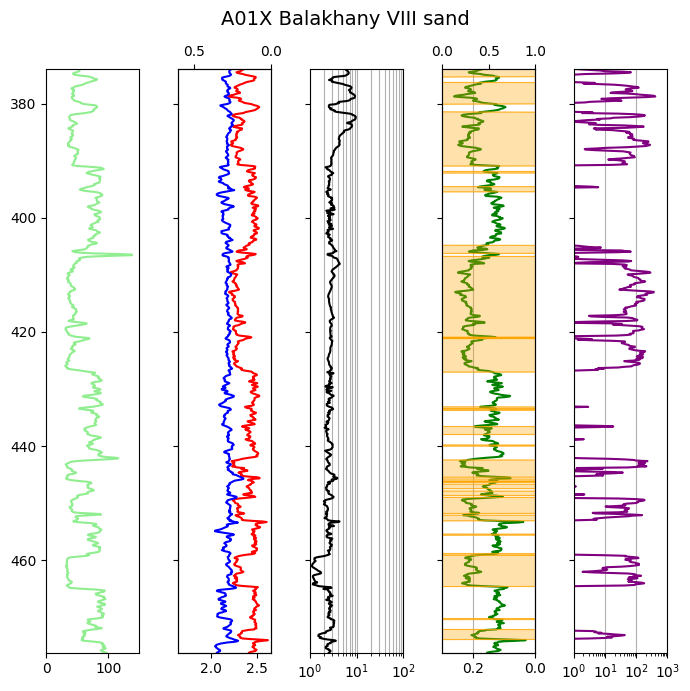

In [111]:
fmname = 'Balakhany VIII sand'
broken_wells_bal8 = ['A21', 'J04', 'E39', 'H01Z']
# for wellname in df_8chg_test_flt[~df_8chg_test_flt.well.isin(broken_wells_bal8)].well.unique()[:]:
#     well_display(wellname, fmname)
well_display('A01X', fmname)

## Preparation dataset for RandForReg Bal VIII sand

In [211]:
# Construction of dummy prediction dataframe separately for Bal VIII sand
csg_well_8 = df_khtst_bal_qcl_csg_sel[df_khtst_bal_qcl_csg_sel.FORMATION=='Balakhany VIII sand'].well.unique()
df_prq_gross_tstsum2.rename(columns={'TST_sum':'gross_tst'}, inplace=True)
df_prq_gross_tst = df_prq_gross_tstsum2.drop(['FORMATION','tst_qc'], axis=1)
df_fu_tst_final_bal8 = df_fu_tst_final[df_fu_tst_final.FORMATION=='Balakhany VIII sand']
df_fu_tst_final_bal8 = df_fu_tst_final_bal8[['well', 'TST_interv']]
df_khtst_xy_8_chg_full = pd.concat([df_khtst_xy_8_chg, df_khtst_xy_8_inj_chg])
df_khtst_8chg = df_khtst_xy_8_chg_full.drop(['FORMATION','KH_log10','Status', 'field'], axis=1)
df_khtst_8chg_dist = df_khtst_8chg.set_index('well').join(distance_bal8_final).reset_index()
df_khtst_8chg_dist = df_khtst_8chg_dist[~df_khtst_8chg_dist.well.isin(csg_well_8)]
df_khtst_8chg_dist_gross = df_khtst_8chg_dist.set_index('well').join(df_prq_gross_tst.set_index('well')) 
df_khtst_8chg_dist_gross_interv = df_khtst_8chg_dist_gross.join(df_fu_tst_final_bal8.set_index('well'))
df_khtst_8chg_dist_gross_interv_qty = df_khtst_8chg_dist_gross_interv.join(df_qty_htst_bal8.set_index('well'))
df_8chg_test = df_khtst_8chg_dist_gross_interv_qty.copy().reset_index().drop('FORMATION', axis=1)
df_8chg_test.dropna(how='any', axis='rows', inplace=True)
df_8chg_test_filter_1 = ['well', 'KHtst', 'X', 'Y', 'DEPTH', 'TVD_SCS', 'gross_tst', 'TST_interv', 'qty_htst']
df_8chg_test_filter_2 = list(df_8chg_test.well.unique())
df_8chg_test_flt = df_8chg_test.filter(df_8chg_test_filter_1 + df_8chg_test_filter_2)
df_8chg_test_flt = df_8chg_test_flt[~df_8chg_test_flt.well.isin(broken_wells_bal8)].reset_index().drop('index', axis=1)
y = np.array(df_8chg_test_flt['KHtst'].values)
x = np.array(df_8chg_test_flt.drop(['well','KHtst'], axis=1))
# print(df_8chg_test_flt.columns)
df_8chg_test_flt.head()

,well,KHtst,X,Y,DEPTH,TVD_SCS,gross_tst,TST_interv,qty_htst,...,A13X,A21,E26,E36,F01Z,G07Z,H01Y,J15Z,J25
0,A01W,3757.000,520841.045,4439139.661,2552.100,2372.825,59.330,103.000,9.000,...,1715.557,3567.595,8621.362,11456.324,14143.002,12102.597,7135.195,4801.546,7824.274
1,A01X,3326.000,520740.209,4439205.062,2534.110,2364.711,51.880,102.000,7.000,...,1609.850,3448.730,8507.239,11341.869,14027.393,11982.997,7020.300,4682.308,7715.829
2,A01Y,727.000,520700.576,4439098.001,2497.070,2382.072,66.930,106.000,10.000,...,1581.792,3461.503,8566.943,11399.862,14082.141,12012.628,7078.812,4723.762,7783.981
3,A03Z,4010.000,520622.494,4439485.774,2549.190,2331.709,63.240,105.000,11.000,...,1497.912,3227.527,8214.631,11050.845,13739.189,11727.043,6728.690,4411.456,7419.656
4,A05,1575.000,521153.971,4439747.973,2714.700,2330.580,58.640,109.000,10.000,...,2059.547,3643.858,8366.611,11204.003,13907.560,12025.449,6896.187,4690.390,7510.006


In [113]:
# # Checking indices and counting x_train dataset
# cc = 0
# for i in df_8chg_test_flt.index:
#     for j in range(len(x_train)):
#         if (x_train[j][0]) == df_8chg_test_flt.iloc[i][0]:
#             print('df_8chg_test_flt.index: ', i, 'x_train.index: ',j)
#             cc += 1
# print('total values in x_train:', cc)

In [114]:
# # Apply StandardScaler to dummy dataset
# scaler = StandardScaler()
# df_8chg_test_flt_ss = pd.DataFrame(scaler.fit_transform(df_8chg_test_flt.iloc[:,1:]), columns=df_8chg_test_flt.iloc[:,1:].columns)
# df_8chg_test_flt_ss_1 = df_8chg_test_flt.iloc[:,:1].join(df_8chg_test_flt_ss)
# df_8chg_test_flt_ss_1

In [209]:
# # Finding correlation to KHtst through dummy dataframe for prediction
# corr = df_8chg_test_flt.iloc[:,1:].corr(method='spearman')
# cor_target = abs(corr['KHtst'])
# cor_tg_df = pd.DataFrame(cor_target.sort_values(ascending=False)).reset_index()
# cor_tg_df.rename(columns={'index':'feature', 'KHtst':'corr'}, inplace=True)
# print('head corr:\n', cor_tg_df.head(10))
# print('tail corr:\n',cor_tg_df.tail(10))

In [116]:
# #from sklearn.linear_model import LinearRegression
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# #Creating our inital test classifier
# LR = LinearRegression()
# LR.fit(x_train, y_train)
# y_pred_train = LR.predict(x_train)
# y_pred = LR.predict(x_test)
# df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# df_results_train = pd.DataFrame({'Actual train': y_train, 'Predicted train': y_pred_train})
# #Plotting actual vs predicted values
# plt.figure(num=None, figsize=(6, 6), dpi=100)
# plt.scatter(df_results_train['Actual train'], df_results_train['Predicted train'], color='crimson')
# plt.xlabel('Actual KHtst'), plt.ylabel('Predicted KHtst'), plt.title('Model Accuracy')
# # plt.xlim(-1, 1), plt.ylim(-1, 1)
# plt.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, y_pred_train, 1))(np.unique(y_train)), color='red')
# plt.show()
# r2_test = r2(y_test, y_pred)
# mae_test = mae(y_test, y_pred)
# mse_test = mse(y_test, y_pred)
# print(f'R2 test: {r2_test.round(2)}', f'MAE test: {mae_test.round(0)}',f'sqrt MSE test: {np.sqrt(mse_test.round(0)):.0f}')
# r2_train = r2(y_train, y_pred_train)
# mae_train = mae(y_train, y_pred_train)
# mse_train = mse(y_train, y_pred_train)
# print(f'R2 train: {r2_train.round(2)}', f'MAE train: {mae_train.round(0)}', f'MSE train: {mse_train.round(0)}')

In [117]:
# # LR.coef
# LR.coef_
# feature_importances = pd.DataFrame(LR.coef_)
# feature_importances.join(pd.DataFrame(df_8chg_test_flt.columns), rsuffix='name').sort_values(by='0',ascending=False).head(15)

## Dummy run RandomForestRegressor for Bal VIII sand

In [ ]:
#Base settings for MLFlow tracking
mlflow.set_tracking_uri("http://16.171.23.137:5000")
mlflow.set_experiment('SPP_RandForReg')

In [556]:
#Reading kavg_htst, groupby it for well & formation
df_htst_avgprop = pd.read_csv('df_prq_htst_avgprop_v1.csv')
df_htst_avgprop['kavg_htst'] = df_htst_avgprop.h_tst * df_htst_avgprop.md_perm_avg
# df_htst_avgprop_gb = df_htst_avgprop.groupby(['well','FORMATION'])['kavg_htst'].sum().reset_index()
df_htst_avgprop

,well,FORMATION,h_tst,md_perm_avg,md_phit_avg,md_vsh_avg,kavg_htst
0,A01W,Balakhany V,0.700,1.000,0.160,0.380,0.700
1,A01W,Balakhany V,0.900,27.000,0.190,0.250,24.300
2,A01W,Balakhany V,0.400,0.000,0.150,0.470,0.000
3,A01W,Balakhany V,1.200,5.000,0.180,0.300,6.000
4,A01W,Balakhany V,0.300,2.000,0.170,0.400,0.600
...,...,...,...,...,...,...,...
64967,J32,Balakhany X 40,0.900,0.000,0.150,0.390,0.000
64968,J32,Balakhany X 40,0.000,0.000,0.150,0.390,0.000
64969,J32,Balakhany X 20,0.000,0.000,0.150,0.390,0.000
64970,J32,Balakhany X 20,0.200,1.000,0.160,0.410,0.200


In [618]:
# #Build scatter plot for h_tst vs perm_avg 
# px.scatter(df_htst_avgprop_nz, x='h_tst', y='md_perm_avg', log_y=True)

In [575]:
#Preparation simple df_htst_avgprop-dataset without distances
df_htst_avgprop_gb = df_htst_avgprop.groupby(['well','FORMATION'])[['kavg_htst', 'md_phit_avg','md_vsh_avg']].agg(
                                             {'kavg_htst':'sum', 'md_phit_avg':'mean', 'md_vsh_avg':'mean' }).reset_index()
df_htst_avgprop_gb = df_htst_avgprop_gb[df_htst_avgprop_gb.FORMATION == 'Balakhany VIII sand']
df_htst_avgprop_gb = df_htst_avgprop_gb[['well', 'FORMATION', 'kavg_htst', 'md_phit_avg', 'md_vsh_avg']]
df_8chg_test_flt_nodist = df_8chg_test.filter(df_8chg_test_filter_1)
df_8chg_test_flt_nodist = df_8chg_test_flt_nodist[~df_8chg_test_flt_nodist.well.isin(broken_wells_bal8)].reset_index().drop('index', axis=1)
df_8chg_test_flt_nodist_enrich = df_8chg_test_flt_nodist.set_index('well').join(df_htst_avgprop_gb.drop('FORMATION', axis=1).set_index('well')).reset_index()
df_8chg_test_flt_nodist_enrich.rename(columns={'TST_interv':'interv_tst'}, inplace=True)
df_8chg_test_flt_nodist_enrich.drop(['qty_htst'] , axis=1, inplace=True)
y1 = np.array(df_8chg_test_flt_nodist_enrich['KHtst'].values)
x1 = np.array(df_8chg_test_flt_nodist_enrich.drop(['well','KHtst','kavg_htst'], axis=1))
# X_train/x_test data splitting
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.33, random_state=42)
# df_8chg_test_flt_nodist_enrich.head()

In [648]:
# # Comparison kavg_tst vs KHtst
# fig1=px.scatter(df_8chg_test_flt_nodist_enrich, x='kavg_htst', y='KHtst')
# fig1.update_traces(marker=dict(size=10))
# fig2=px.line(x=[0,5000,10000,15000], y=[0,5000,10000,15000])
# fig2.update_traces(line=dict(color = 'red'))
# fig3 = go.Figure(data = fig1.data + fig2.data)
# fig3.update_layout(title = 'Comparison kavg_tst vs KHtst',width=700,height=400, xaxis_title="kavg_htst", yaxis_title="KHtst",
#                    margin=dict(l=10,r=10,b=10,t=40))
# fig3.show()

In [179]:
#Display on map x_train & x_test for Chirag
fig = go.Figure()
field_avg_coord_chg = field_avg_coord[field_avg_coord.field.isin(chg_lst)]
# field_avg_coord_azr = field_avg_coord[field_avg_coord.field.isin(azr_lst)] 
fig.add_trace(go.Scatter(x=x_train[:,0], y=x_train[:,1], 
                         marker=dict(color='rgb(255, 255, 255)', size=y_train*0.0025, line=dict(color='rgb(252, 48, 3)', width=3)),
                         mode='markers', name='train set'))
fig.add_trace(go.Scatter(x=x_test[:,0], y=x_test[:,1], 
                         marker=dict(color='rgb(255, 255, 255)', size=y_test*0.0025, line=dict(color='rgb(52, 61, 235)', width=3)),
                         mode='markers', name='test set'))
fig.add_trace(go.Scatter(x=list(df_8chg_test_flt.X), y=list(df_8chg_test_flt.Y), customdata = df_8chg_test_flt[['well', 'KHtst']],
                         marker=dict(color=df_8chg_test_flt.TVD_SCS, size=df_8chg_test_flt.KHtst*0.0025, colorscale='Viridis_r',  showscale=True,
                         line=dict(color='rgb(47, 57, 61)', width=0.5)),
                         mode='markers', name='KHtst wells', hovertemplate="".join(["well:%{customdata[0]}, KHtst:%{customdata[1]}<extra></extra>"])))
fig.add_trace(go.Scatter(x=field_avg_coord_chg.X_wellhead, y=field_avg_coord_chg.Y_wellhead, customdata = field_avg_coord_chg[['field']],
                         text=field_avg_coord_chg['field'], textposition="middle right",
                         marker=dict(color='rgb(0, 0,0)', size=12),
                         mode='markers+text', name='Platforms', 
                         marker_symbol='square', hovertemplate="".join(["%{customdata[0]}<extra></extra>"])))
fig.update_layout(title_text='Balakhany VIII sand KHtst, size=f(KHtst), color=f(TVD_SCS) for RFR prediction',
                  autosize=True, width=1000, height=500, margin=dict(l=10,r=10,b=10,t=50))
fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="right", x=1, bgcolor='rgba(255,255,255,1)', bordercolor='Black',borderwidth=1))
fig.show()
print('wells on map ', len(df_8chg_test_flt.well.unique()))
print('wells x_train', len(x_train[:,0]))
print('well x_test', len(x_test[:,0]))

wells on map  85
wells x_train 56
well x_test 29


In [576]:
#Gridsearch test run for RandForRegr Bal VIII sand
RF1 = RandomForestRegressor()
grid_param_RF1 = {
    'bootstrap': [True, False],
    'max_depth': [None, 10, 50, 75, 100, 150, 200, 500],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'min_samples_split': [1, 2, 3, 5, 10, 20],
    'n_estimators': [10, 25, 50, 100, 200]}
gd_sr_RF1 = GridSearchCV(estimator = RF1, param_grid = grid_param_RF1, scoring='r2', cv = None, n_jobs = -1)
gd_sr_RF1.fit(x1_train, y1_train)
print(gd_sr_RF1.best_params_)

{'bootstrap': True, 'max_depth': 150, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}


In [665]:
df_results_v1

,Actual,Predicted
0,6713.000,4691.039
1,3757.000,4765.455
2,5765.000,6159.705
3,6786.000,5383.831
4,4118.000,4374.257
5,2530.000,4493.740
6,1065.000,1579.028
7,1997.000,2801.280
8,1575.000,4084.720
9,10879.000,6576.437


In [678]:
# RandomForestRegressor for Bal VIII sand
# with mlflow.start_run(run_name='rfm_gs_r2'):
      # mlflow.set_tag("model_name", "RandForReg")
RF_setting = {'bootstrap':True, 
                  'max_depth':150, 
                  'min_samples_leaf':1, 
                  'min_samples_split':10,
                  'n_estimators':10} 
RF = RandomForestRegressor(bootstrap= RF_setting['bootstrap'], 
                              max_depth=RF_setting['max_depth'], 
                              min_samples_leaf=RF_setting['min_samples_leaf'], 
                              min_samples_split=RF_setting['min_samples_split'], 
                              n_estimators=RF_setting['n_estimators'])
RF.fit(x1_train, y1_train)
#Returning our prediction values for the test data
y1_pred_train = RF.predict(x1_train)
y1_pred = RF.predict(x1_test)
#Combining the actual and predicted values into a single df
df_results_v1 = pd.DataFrame({'Actual': y1_test, 'Predicted': y1_pred})
result_ml_plot(res = df_results_v1, dataset = df_8chg_test_flt_nodist_enrich, kh='KHtst')
# #Plotting actual vs predicted values
# plt.figure(num=None, figsize=(5, 5), dpi=100)
# plt.scatter(df_results['Actual'], df_results['Predicted'], color='crimson')
# plt.xlabel('Actual KHtst'), plt.ylabel('Predicted KHtst'), plt.title('Model Accuracy 1st version')
# plt.xlim(0, 13000), plt.ylim(0, 13000)
# plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')
# plt.grid()
# plt.show()
r2_test = r2(y1_test, y1_pred)
mae_test = mae(y1_test, y1_pred)
mse_test = mse(y1_test, y1_pred)
print(f'R2 test: {r2_test.round(2)}', 
      f'MAE test: {mae_test.round(0)}',
      f'sqrt MSE test: {np.sqrt(mse_test.round(0)):.0f}')
r2_train = r2(y1_train, y1_pred_train)
mae_train = mae(y1_train, y1_pred_train)
mse_train = mse(y1_train, y1_pred_train)
print(f'R2 train: {r2_train.round(2)}', 
      f'MAE train: {mae_train.round(0)}', 
      f'sqrt MSE train: {np.sqrt(mse_train.round(0)):.0f}')

      # mlflow.log_param("bootstrap", RF_setting['bootstrap'])
      # mlflow.log_param("max_depth", RF_setting['max_depth'])
      # mlflow.log_param("min_samples_leaf", RF_setting['min_samples_leaf'])
      # mlflow.log_param("min_samples_split", RF_setting['min_samples_split'])
      # mlflow.log_param("n_estimators", RF_setting['n_estimators'])

      # mlflow.log_metric("r2_test", r2_test)
      # mlflow.log_metric("mae_test", mae_test)
      # mlflow.log_metric("mse_test", mse_test)

      # mlflow.sklearn.log_model(RF, "RFR_models")

R2 test: 0.63 MAE test: 1507.0 sqrt MSE test: 2089
R2 train: 0.82 MAE train: 989.0 sqrt MSE train: 1333


In [208]:
# # Actual and predicted values comparison
# well_khtst = df_8chg_test_flt_nodist_enrich[['well','KHtst']]
# df_results_fin = df_results.set_index('Actual').join(well_khtst.set_index('KHtst')).reset_index()
# df_results_fin['diff'] = df_results_fin.Actual - df_results_fin.Predicted
# df_results_fin.sort_values(by='diff')

In [358]:
# # RF.feature_importances
# RF.feature_importances_
# feature_importances = pd.DataFrame(RF.feature_importances_)
# feature_importances.join(pd.DataFrame(df_8chg_test_flt.columns), rsuffix='name').sort_values(by='0',ascending=False).head(15)

In [356]:
# #Drawing the bar-chart for feature inportance, but check the column's names
# feature_importances['feature_name'] = x_train.columns.tolist()
# feature_importances['importance'] = RF.feature_importances_
# feature_importances = feature_importances.sort_values(by='importance', ascending=False)
# feature_importances = feature_importances[:15]
# fig = px.bar(feature_importances, 
#              x=feature_importances['importance'], 
#              y=feature_importances['feature_name'], 
#              title=f'Feature importances + r2 train:{r2_train:.2f}')
# fig.update_layout(yaxis={'categoryorder':'total ascending'}, width=700, height=700, margin=dict(l=10, r=10, t=50, b=10))
# fig.show()

In [129]:
# # RandomForestRegressor for Bal VIII sand several iterations run
# N = 10
# r2_lst = []
# gr_sr_lst = []
# for i in range(N):
#     #Assign x & y arrays
#     y = np.array(df_8chg_test_flt_nodist_enrich['KHtst'].values)
#     x = np.array(df_8chg_test_flt_nodist_enrich.drop(['well','KHtst'], axis=1))
#     #Gridsearch test run for RandForRegr Bal VIII sand
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#     #Creating our inital test classifier
#     RF = RandomForestRegressor()
#     #Selecting our algorithm variables that will be tested on our dataset and running them through a grid search
#     grid_param_RF = {
#         'bootstrap': [True],
#         'max_depth': [10, 50, 75, 100, 150, 200, 500],
#         'min_samples_leaf': [2, 3, 5, 10],
#         'min_samples_split': [2, 3, 5, 10, 20],
#         'n_estimators': [10, 25, 50, 100, 200]}
#     gd_sr_RF = GridSearchCV(estimator = RF, param_grid = grid_param_RF, cv = 3, n_jobs = -1)
#     gd_sr_RF.fit(x_train, y_train)
#     #Adjusting our model parameters and fitting them to our test/train data
#     RF = RandomForestRegressor(bootstrap= gd_sr_RF.best_params_['bootstrap'], 
#                                max_depth=gd_sr_RF.best_params_['max_depth'], 
#                                min_samples_leaf=gd_sr_RF.best_params_['min_samples_leaf'], 
#                                min_samples_split=gd_sr_RF.best_params_['min_samples_split'], 
#                                n_estimators=gd_sr_RF.best_params_['n_estimators'])
#     RF.fit(x_train, y_train)
#     #Returning our prediction values for the test data
#     y_pred_train = RF.predict(x_train)
#     y_pred = RF.predict(x_test)
#     #Combining the actual and predicted values into a single df
#     # df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#     r2_train = r2(y_train, y_pred_train)
#     r2_test = r2(y_test, y_pred)
#     r2_lst.append(r2_test)
#     gr_sr_lst.append(gd_sr_RF.best_params_['min_samples_leaf'])
# print('r2_lst', r2_lst)
# print('best_params', gr_sr_lst)

In [128]:
# # RF.feature_importances
# RF.feature_importances_
# feature_importances = pd.DataFrame(RF.feature_importances_)
# feature_importances.join(pd.DataFrame(df_8chg_test_flt.columns), rsuffix='name').sort_values(by='0',ascending=False).head(15)

In [578]:
#Preparation weighted average df_htst_avgprop-dataset
cutoff_h_tst = 0.5
cutoff_perm_avg = 5
#Applying filtration to dataset with cutoffs
df_htst_avgprop_nz = df_htst_avgprop[(df_htst_avgprop.h_tst > cutoff_h_tst) & (df_htst_avgprop.md_perm_avg > cutoff_perm_avg)]
#Multiplaying htst by resprop values
df_htst_avgprop_nz['kavg_htst'] = df_htst_avgprop_nz.h_tst * df_htst_avgprop_nz.md_perm_avg
df_htst_avgprop_nz['phit_htst'] = df_htst_avgprop_nz.h_tst * df_htst_avgprop_nz.md_phit_avg
df_htst_avgprop_nz['vsh_htst'] = df_htst_avgprop_nz.h_tst * df_htst_avgprop_nz.md_vsh_avg
#Summarizing h_tst via well & formation
df_htst_fm = df_htst_avgprop_nz.groupby(['well','FORMATION'])['h_tst'].sum().reset_index()
df_htst_fm.rename(columns={'h_tst':'h_tst_sum'}, inplace=True)
#Calculating weighted averages
df_htst_avgprop_nz_avgpropsum = df_htst_avgprop_nz.groupby(['well','FORMATION'])[['phit_htst','vsh_htst']].sum().reset_index()
df_htst_avgprop_nz_avgpropsum_join = df_htst_avgprop_nz_avgpropsum.set_index(['well','FORMATION']).join(df_htst_fm.set_index(['well','FORMATION'])).reset_index()
df_htst_avgprop_nz_avgpropsum_join['phit_wavg'] = df_htst_avgprop_nz_avgpropsum_join.phit_htst / df_htst_avgprop_nz_avgpropsum_join.h_tst_sum
df_htst_avgprop_nz_avgpropsum_join['vsh_wavg'] = df_htst_avgprop_nz_avgpropsum_join.vsh_htst / df_htst_avgprop_nz_avgpropsum_join.h_tst_sum
df_8bal_hpv = df_htst_avgprop_nz_avgpropsum_join[
              df_htst_avgprop_nz_avgpropsum_join.FORMATION == 'Balakhany VIII sand'][['well','FORMATION','h_tst_sum','phit_wavg','vsh_wavg']]
df_8bal_permh = df_htst_avgprop_nz[df_htst_avgprop_nz.FORMATION == 'Balakhany VIII sand'].groupby(['well','FORMATION'])['kavg_htst'].sum().reset_index()
df_8bal_phhpv = df_8bal_hpv.set_index(['well','FORMATION']).join(df_8bal_permh.set_index(['well','FORMATION'])).reset_index()
#Preparing x,y matrices for ML
df_8chg_test_flt_nodist_v2 = df_8chg_test_flt_nodist.drop(['gross_tst', 'qty_htst'], axis=1) 
df_8chg_test_flt_nodist_v2.rename(columns={'TST_interv':'interv_tst'}, inplace=True)
df_8chg = df_8chg_test_flt_nodist_v2.set_index('well').join(df_8bal_phhpv.set_index('well')).reset_index()
df_8chg = df_8chg.drop(['KHtst', 'FORMATION'], axis=1)
y2 = np.array(df_8chg['kavg_htst'].values)
x2 = np.array(df_8chg.drop(['well','kavg_htst'], axis=1))
#X_train/x_test data splitting
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.33, random_state=10)

In [579]:
#Gridsearch test run for RandForRegr Bal VIII sand
RF2 = RandomForestRegressor()
grid_param_RF2 = {
    'bootstrap': [True, False],
    'max_depth': [None, 10, 50, 75, 100, 150, 200, 500],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'min_samples_split': [1, 2, 3, 5, 10, 20],
    'n_estimators': [10, 25, 50, 100, 200]}
gd_sr_RF2 = GridSearchCV(estimator = RF2, param_grid = grid_param_RF2, scoring='r2', cv = None, n_jobs = -1)
gd_sr_RF2.fit(x2_train, y2_train)
print(gd_sr_RF2.best_params_)

{'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


In [679]:
def result_ml_plot(res = df_results, dataset = df_8chg, kh = 'kavg_htst' ):
    """
    res = dataset with results of ML prediction
    dataset = dataframe with wellnames to join it with res based on actual KHtst values
    """
    final = res.set_index('Actual').join(dataset[['well', kh]].set_index(kh)).reset_index()
    fig1_ml = px.scatter(final, x='Actual', y='Predicted', hover_data=['well'], width=400, height=400)
    fig1_ml.update_traces(marker=dict(size=10))
    fig2_ml=px.line(x=[0,5000,10000,12000], y=[0,5000,10000,12000])
    fig2_ml.update_traces(line=dict(color = 'red'))
    fig3_ml = go.Figure(data = fig1_ml.data + fig2_ml.data)
    fig3_ml.update_layout(title = 'Comparison Actual vs Pred',width=400,height=400, xaxis_title="KHtst_test", yaxis_title="KHtst_pred",
                    margin=dict(l=10,r=10,b=10,t=40))
    return fig3_ml.show()

In [680]:
# RandomForestRegressor for Bal VIII sand weighted avg df_htst_avgprop-dataset 
# with mlflow.start_run(run_name='rfm_weighted_avg_gs_r2'):
# mlflow.set_tag("model_name", "RandForReg")
RF_setting = {'bootstrap':True, 
                  'max_depth':50, 
                  'min_samples_leaf':1, 
                  'min_samples_split':3,
                  'n_estimators':100} 
RF = RandomForestRegressor(bootstrap= RF_setting['bootstrap'], 
                              max_depth=RF_setting['max_depth'], 
                              min_samples_leaf=RF_setting['min_samples_leaf'], 
                              min_samples_split=RF_setting['min_samples_split'], 
                              n_estimators=RF_setting['n_estimators'])
RF.fit(x2_train, y2_train)
#Returning our prediction values for the test data
y2_pred_train = RF.predict(x2_train)
y2_pred = RF.predict(x2_test)
#Combining the actual and predicted values into a single df
df_results = pd.DataFrame({'Actual': y2_test, 'Predicted': y2_pred})
result_ml_plot(df_results, df_8chg)

r2_test = r2(y2_test, y2_pred)
mae_test = mae(y2_test, y2_pred)
mse_test = mse(y2_test, y2_pred)
print(f'R2 test: {r2_test.round(2)}', 
      f'MAE test: {mae_test.round(0)}',
      f'sqrt MSE test: {np.sqrt(mse_test.round(0)):.0f}')
r2_train = r2(y2_train, y2_pred_train)
mae_train = mae(y2_train, y2_pred_train)
mse_train = mse(y2_train, y2_pred_train)
print(f'R2 train: {r2_train.round(2)}', 
      f'MAE train: {mae_train.round(0)}', 
      f'sqrt MSE train: {np.sqrt(mse_train.round(0)):.0f}')

      # mlflow.log_param("bootstrap", RF_setting['bootstrap'])
      # mlflow.log_param("max_depth", RF_setting['max_depth'])
      # mlflow.log_param("min_samples_leaf", RF_setting['min_samples_leaf'])
      # mlflow.log_param("min_samples_split", RF_setting['min_samples_split'])
      # mlflow.log_param("n_estimators", RF_setting['n_estimators'])

      # mlflow.log_metric("r2_test", r2_test)
      # mlflow.log_metric("mae_test", mae_test)
      # mlflow.log_metric("mse_test", mse_test)

      # mlflow.sklearn.log_model(RF, "RFR_models")

R2 test: 0.83 MAE test: 646.0 sqrt MSE test: 905
R2 train: 0.97 MAE train: 433.0 sqrt MSE train: 639


In [ ]:
# # v1 Split train vs test dataframe for separately for Bal VIII sand
# def select_random_Ns(l, p):
#     random.shuffle(l)
#     res = []
#     k = int(round(len(l)*p,0))
#     for i in range(k):
#         res.append(l[i])
#     return res  
# N = 100
# r2_test_lst = []
# r2_train_lst = []
# # model = RandomForestRegressor(n_estimators=100, random_state=42,
# #                               max_features="sqrt", max_depth=70, bootstrap=True,
# #                               min_samples_leaf=1)
# model = RandomForestRegressor(random_state=42)
# for i in tqdm(range(N)):
#     well_test = select_random_Ns(df_8chg_test_flt_ss_1.well.unique(), 0.3)
#     well_train = df_8chg_test_flt[~df_8chg_test_flt_ss_1.well.isin(well_test)].well.unique()
#     # print('index of lop:', i)
#     # print('x_train', len(well_train), well_train)
#     # print('x_test', len(well_test), well_test)
#     x_train = df_8chg_test_flt_ss_1[df_8chg_test_flt_ss_1.well.isin(well_train)]
#     y_train = x_train['KHtst']
#     x_train.drop(['well', 'KHtst'], axis=1, inplace=True)
#     x_test = df_8chg_test_flt_ss_1[df_8chg_test_flt_ss_1.well.isin(well_test)]
#     y_test = x_test['KHtst']
#     x_test.drop(['well', 'KHtst'], axis=1, inplace=True)
#     #Run RandomForestRegressor and print results
#     model.fit(x_train, y_train)
#     y_pred_train = model.predict(x_train)
#     y_pred_test = model.predict(x_test)
#     # print('Predicted values from train data:')
#     r2_train = r2(y_train, y_pred_train)
#     mae_train = mae(y_train, y_pred_train)
#     mse_train = mse(y_train, y_pred_train)
#     # print(f'R2 train: {r2_train.round(2)}')
#     # print(f'MAE train: {mae_train.round(0)}')
#     # print(f'MSE train: {mse_train.round(0)}')
#     r2_train_lst.append(r2_train.round(2))
#     # print('Predicted values from test data:')
#     r2_test = r2(y_test, y_pred_test)
#     mae_test = mae(y_test, y_pred_test)
#     mse_test = mse(y_test, y_pred_test)
#     # print(f'R2 test: {r2_test.round(2)}')
#     # print(f'MAE test: {mae_test.round(0)}')
#     # print(f'MSE test: {mse_test.round(0)}')
#     r2_test_lst.append(r2_test.round(2))
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=r2_test_lst, name='r2_test'))
# fig.add_trace(go.Histogram(x=r2_train_lst, name='r2_train'))
# fig.update_layout(barmode='overlay', 
#                   title = 'r2 uncertainty for test and train {model}',
#                   height=300, width=1200, margin=dict(l=30, r=10, t=40, b=0), xaxis_title='index', yaxis_title='r2')
# fig.show()

In [ ]:
# # v1 Feature importance calculation for 15 most important inputs
# model.feature_importances_
# feature_importances = pd.DataFrame()
# feature_importances['feature_name'] = x_train.columns.tolist()
# feature_importances['importance'] = model.feature_importances_
# feature_importances = feature_importances.sort_values(by='importance', ascending=False)
# feature_importances = feature_importances[:15]
# fig = px.bar(feature_importances, 
#              x=feature_importances['importance'], 
#              y=feature_importances['feature_name'], 
#              title=f'Feature importances + r2 train:{r2_train:.2f}')
# fig.update_layout(yaxis={'categoryorder':'total ascending'}, width=700, height=700, margin=dict(l=10, r=10, t=50, b=10))
# fig.show()

In [ ]:
# # Save datasets to csv
# x_train.to_csv('x_train_2909.csv', index=False, sep=',')
# y_train.to_csv('y_train_2909.csv', index=False, sep=',')
# x_test.to_csv('x_test_2909.csv', index=False, sep=',')
# y_test.to_csv('y_test_2909.csv', index=False, sep=',')